In [1]:
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats
from scipy import sparse 
from statsmodels.sandbox.stats.multicomp import multipletests
import pickle as pkl

Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
adata = sc.read_h5ad("preliminary_results_normalizeTrue_lpsolver_031523.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    obsm: 'X_pca', 'X_umap'

In [4]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from anndata import AnnData
from scanpy.pl._utils import savefig_or_show

"""
Dev notes: Preliminary plotting scripts -- needs testing, show/save implementation
split_violins now runs on the tutorial data and on my data 
"""
class DialoguePlot:
    """Plotting functions for Dialogue."""

    @staticmethod
    def split_violins(
        adata: AnnData, 
        celltype_key: str, 
        split: str, 
        mcp: str="mcp_0", 
        split_tuple: (str,str) | None = None,
        title: str |None = None,
        show: bool | None = None,
        save: bool | str | None = None,
        return_fig: bool = False,
        **kwargs,
        ):
        """Plot MCP results from Dialogue on split violins, with one violin per cell type.

        Args:
            adata: AnnData with MCP scores
            celltype_key: the key in AnnData.obs used to create the violins
            split: the key in AnnData.obs used to split the violins. Must have exactly 2 values if split_tuple is None
            mcp: the key in AnnData.obs which contains the MCP score being plotted, in the form "mcp_x"
            groupby: the key in AnnData.obs which contains the groups of interest (typically cell type)
            split_tuple: None (if AnnData.obs['split'] has exactly 2 values) or a tuple of strings to subset to only
                cells with those strings in AnnData.obs['split']
            title:
            show:Show the plot, do not return axis.
            save: If `True` or a `str`, save the figure. A string is appended to the default filename.
                  Infer the filetype if ending on {`'.pdf'`, `'.png'`, `'.svg'`}.
            **kwargs: Additional arguments passed to `sns.violinplot`

        """

        if split_tuple is not None:
            df = sc.get.obs_df(adata[adata.obs[split].isin(split_tuple)], [celltype_key,mcp,split])
        else:
            df = sc.get.obs_df(adata, [celltype_key,mcp,split])

        # work save/show into it 
        p2 = sns.violinplot(data=df, x=celltype_key,y=mcp,hue=split, split=True, **kwargs)
        p2.set_xticklabels(p2.get_xticklabels(), rotation=90)
        p2.set(title=title)
        savefig_or_show("split_violin_"+mcp+"_", show=show, save=save)
        if return_fig:
            return(p2)


    @staticmethod
    def mcp_pairplot(
        adata: AnnData,
        celltype_key: str ,
        sample_key: str,
        mcp: str="mcp_0",
        title: str | None = None,
        color: str | None = None,
        show: bool | None = None,
        save: bool | str | None = None,
        return_fig: bool=False,
        **kwargs,
        ):
        """Plot MCP results from Dialogue on a pair plot as in DIALOGUE 

        Args:
            adata: AnnData with MCP scores
            celltype_key: the key in AnnData.obs which contains the celltype key 
            color: the key in AnnData.obs used to color the points and histograms (optional)
            mcp: the key in AnnData.obs which contains the MCP score being plotted
            groupby: the key in AnnData.obs which contains the groups of interest (typically cell type)
            split: the key in AnnData.obs which contains the info being used to split 
            title:
            show:Show the plot, do not return axis.
            save: If `True` or a `str`, save the figure. A string is appended to the default filename.
                  Infer the filetype if ending on {`'.pdf'`, `'.png'`, `'.svg'`}.
            **kwargs: Additional arguments passed to `sns.pairplot`

        """

        ## TODO: figure out how to move the legend to the main plot
        ## OR: print the Pearson correlations like DLG does


        mean_mcp = adata.obs.groupby([sample_key,celltype_key])[mcp].mean()
        mean_mcp = mean_mcp.reset_index()
        mcp_pivot = pd.pivot(mean_mcp[[sample_key,celltype_key,mcp]],index=sample_key,columns = celltype_key )[mcp]
        if color is not None:
            mcp_pivot = pd.concat([mcp_pivot,adata.obs.groupby([sample_key]).agg(pd.Series.mode)[color]],axis=1)
            p2 = sns.pairplot(mcp_pivot, corner=True, hue=color, **kwargs)

        else: 
            p2 = sns.pairplot(mcp_pivot, corner=True, **kwargs)


        if title is not None:
            p2.fig.suptitle(title)
        else:
            p2.fig.suptitle("MCP score "+mcp)

        savefig_or_show("MCP_pairplot_"+mcp+"_", show=show, save=save)
        if return_fig:
            return(p2)


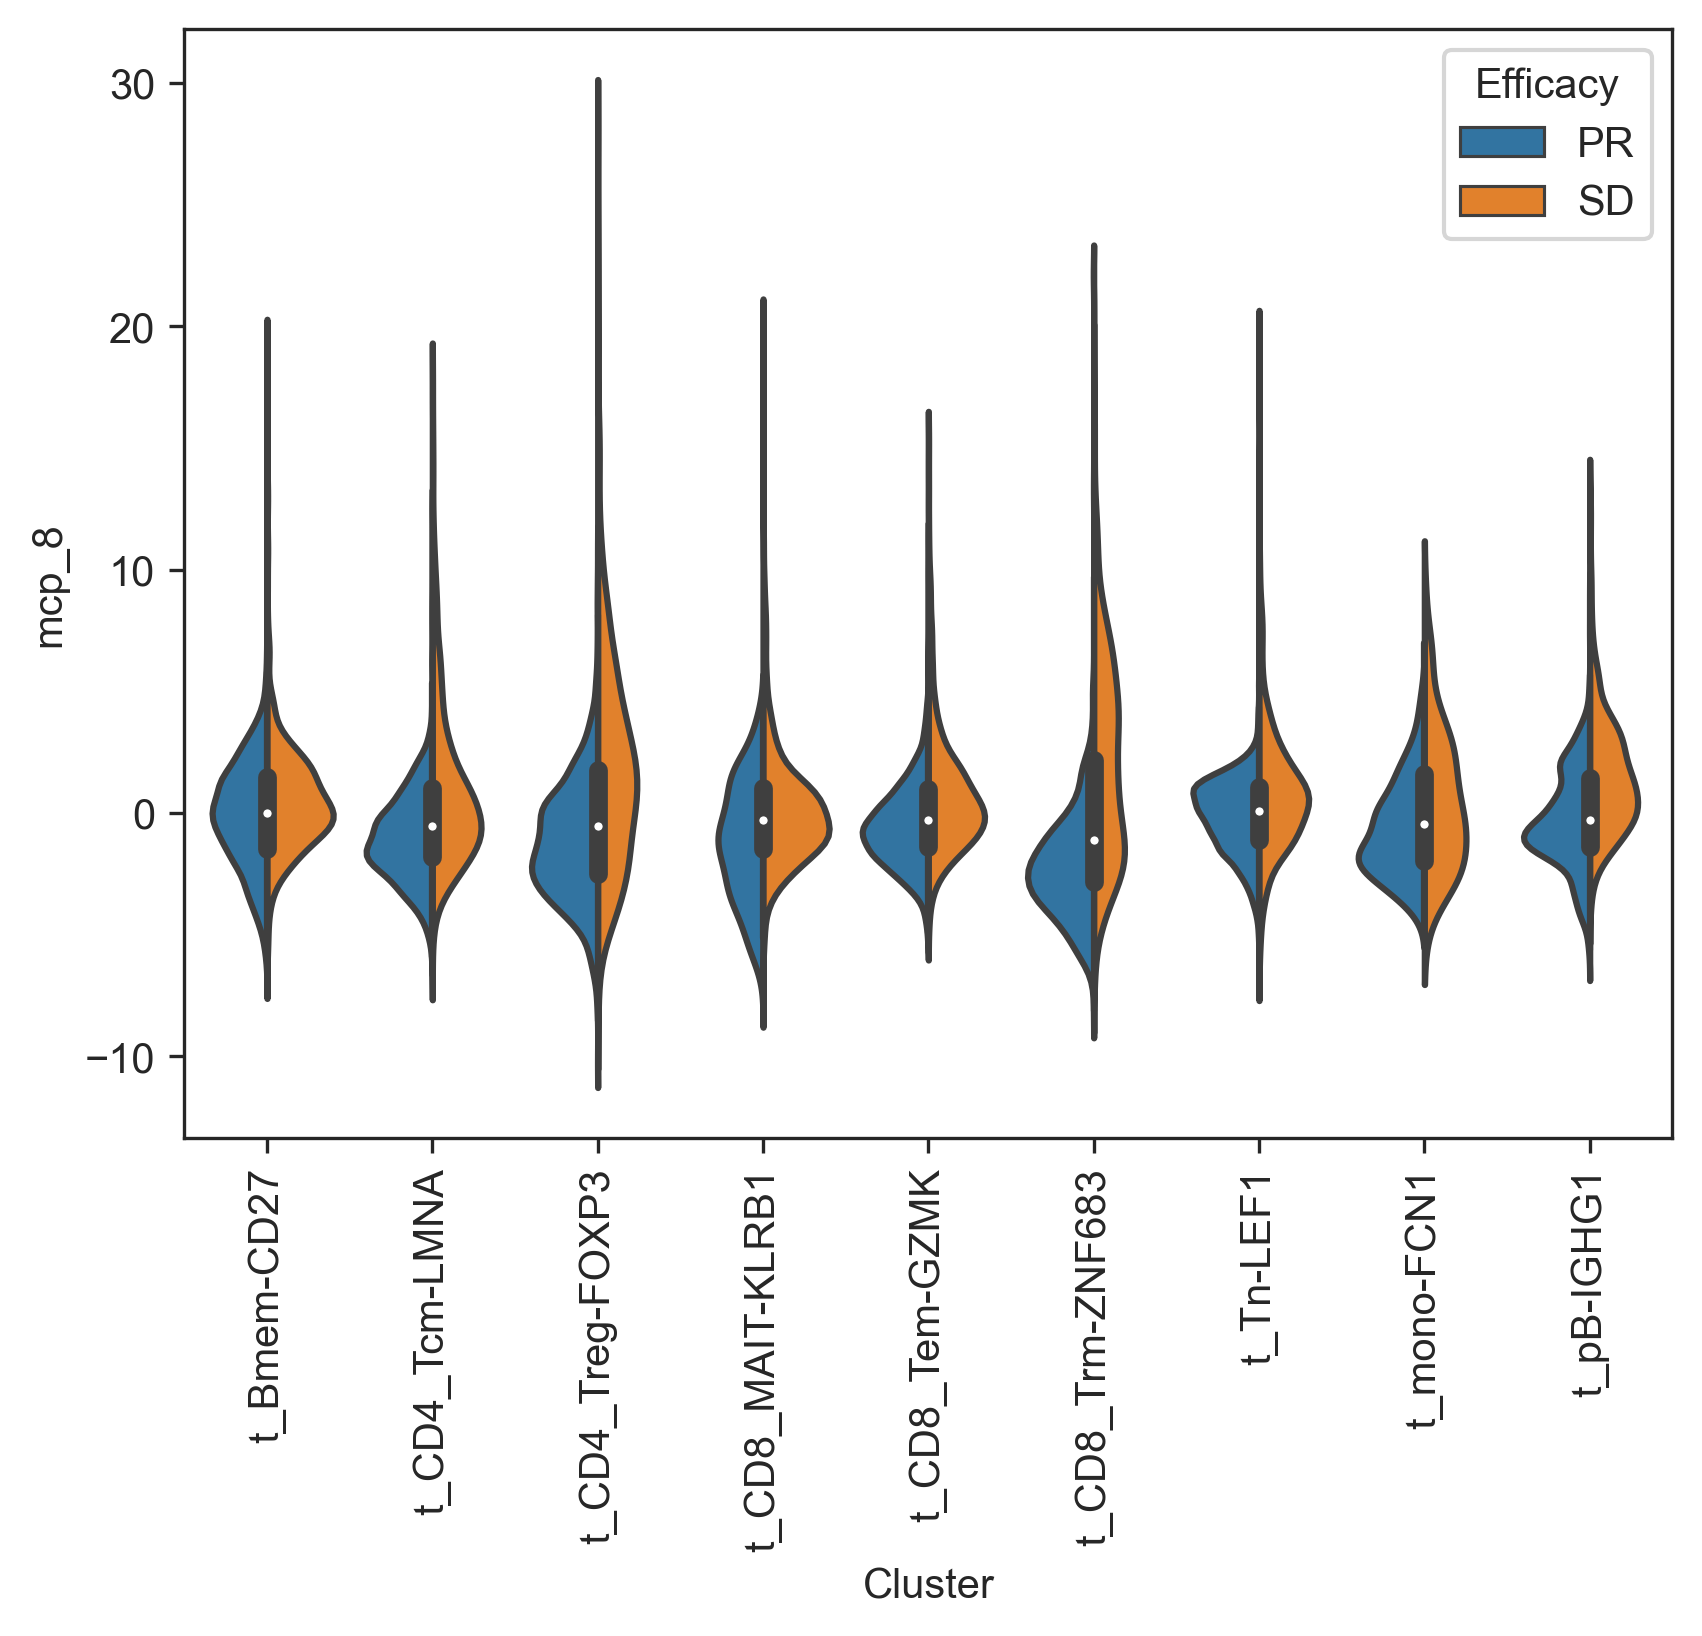

In [5]:
DialoguePlot.split_violins(adata, mcp = "mcp_8",celltype_key = "Cluster", split="Efficacy",show=True, Title = "MCP8 Split Violins")

In [6]:
pklfile =  "preliminary_results_normalizeTrue_lpsolver_031523.pkl"
f_myfile = open(pklfile, 'rb')
a = pkl.load(f_myfile)  # variables come out in the order you put them in
f_myfile.close()

In [7]:
pvals = a['pvals']

In [8]:
pvals # for mcp_8 use only pB
pvals # for mcp_9 could use t_Bmem-CD27, t_CD4_Tcm-LMNA and t_Tn-LEF1	

,mcp_0,mcp_1,mcp_2,mcp_3,mcp_4,mcp_5,mcp_6,mcp_7,mcp_8,mcp_9
t_Bmem-CD27,0.310004,0.282239,0.256739,0.231698,0.206872,0.184201,0.178282,0.182127,0.166883,0.045383
t_CD4_Tcm-LMNA,0.148392,0.142909,0.138914,0.135653,0.133086,0.132820,0.149913,0.165898,0.182158,0.044625
t_CD4_Treg-FOXP3,0.282168,0.276002,0.270366,0.264374,0.258762,0.258327,0.301227,0.339816,0.371245,0.099988
t_CD8_MAIT-KLRB1,0.183989,0.174777,0.166589,0.158533,0.150517,0.143562,0.147647,0.154864,0.166012,0.143123
t_CD8_Tem-GZMK,0.255913,0.242980,0.231025,0.219225,0.207368,0.196301,0.195042,0.195903,0.198859,0.140458
t_CD8_Trm-ZNF683,0.182319,0.175636,0.169802,0.164251,0.158849,0.154397,0.159821,0.163101,0.168662,0.149945
t_Tn-LEF1,0.168134,0.157120,0.148541,0.141139,0.134687,0.130999,0.147705,0.159392,0.173774,0.028501
t_mono-FCN1,0.584216,0.580220,0.574645,0.563744,0.544203,0.512347,0.468519,0.422200,0.418140,0.428275
t_pB-IGHG1,0.543557,0.500692,0.451773,0.391429,0.316196,0.223208,0.099959,0.050454,0.033683,0.408063


In [9]:
pvals.min()

mcp_0    0.148392
mcp_1    0.142909
mcp_2    0.138914
mcp_3    0.135653
mcp_4    0.133086
mcp_5    0.130999
mcp_6    0.099959
mcp_7    0.050454
mcp_8    0.033683
mcp_9    0.028501
dtype: float64

In [10]:
mini = adata[adata.obs['Cluster'].isin(["t_Bmem-CD27", 't_CD4_Tcm-LMNA','t_Tn-LEF1'])]

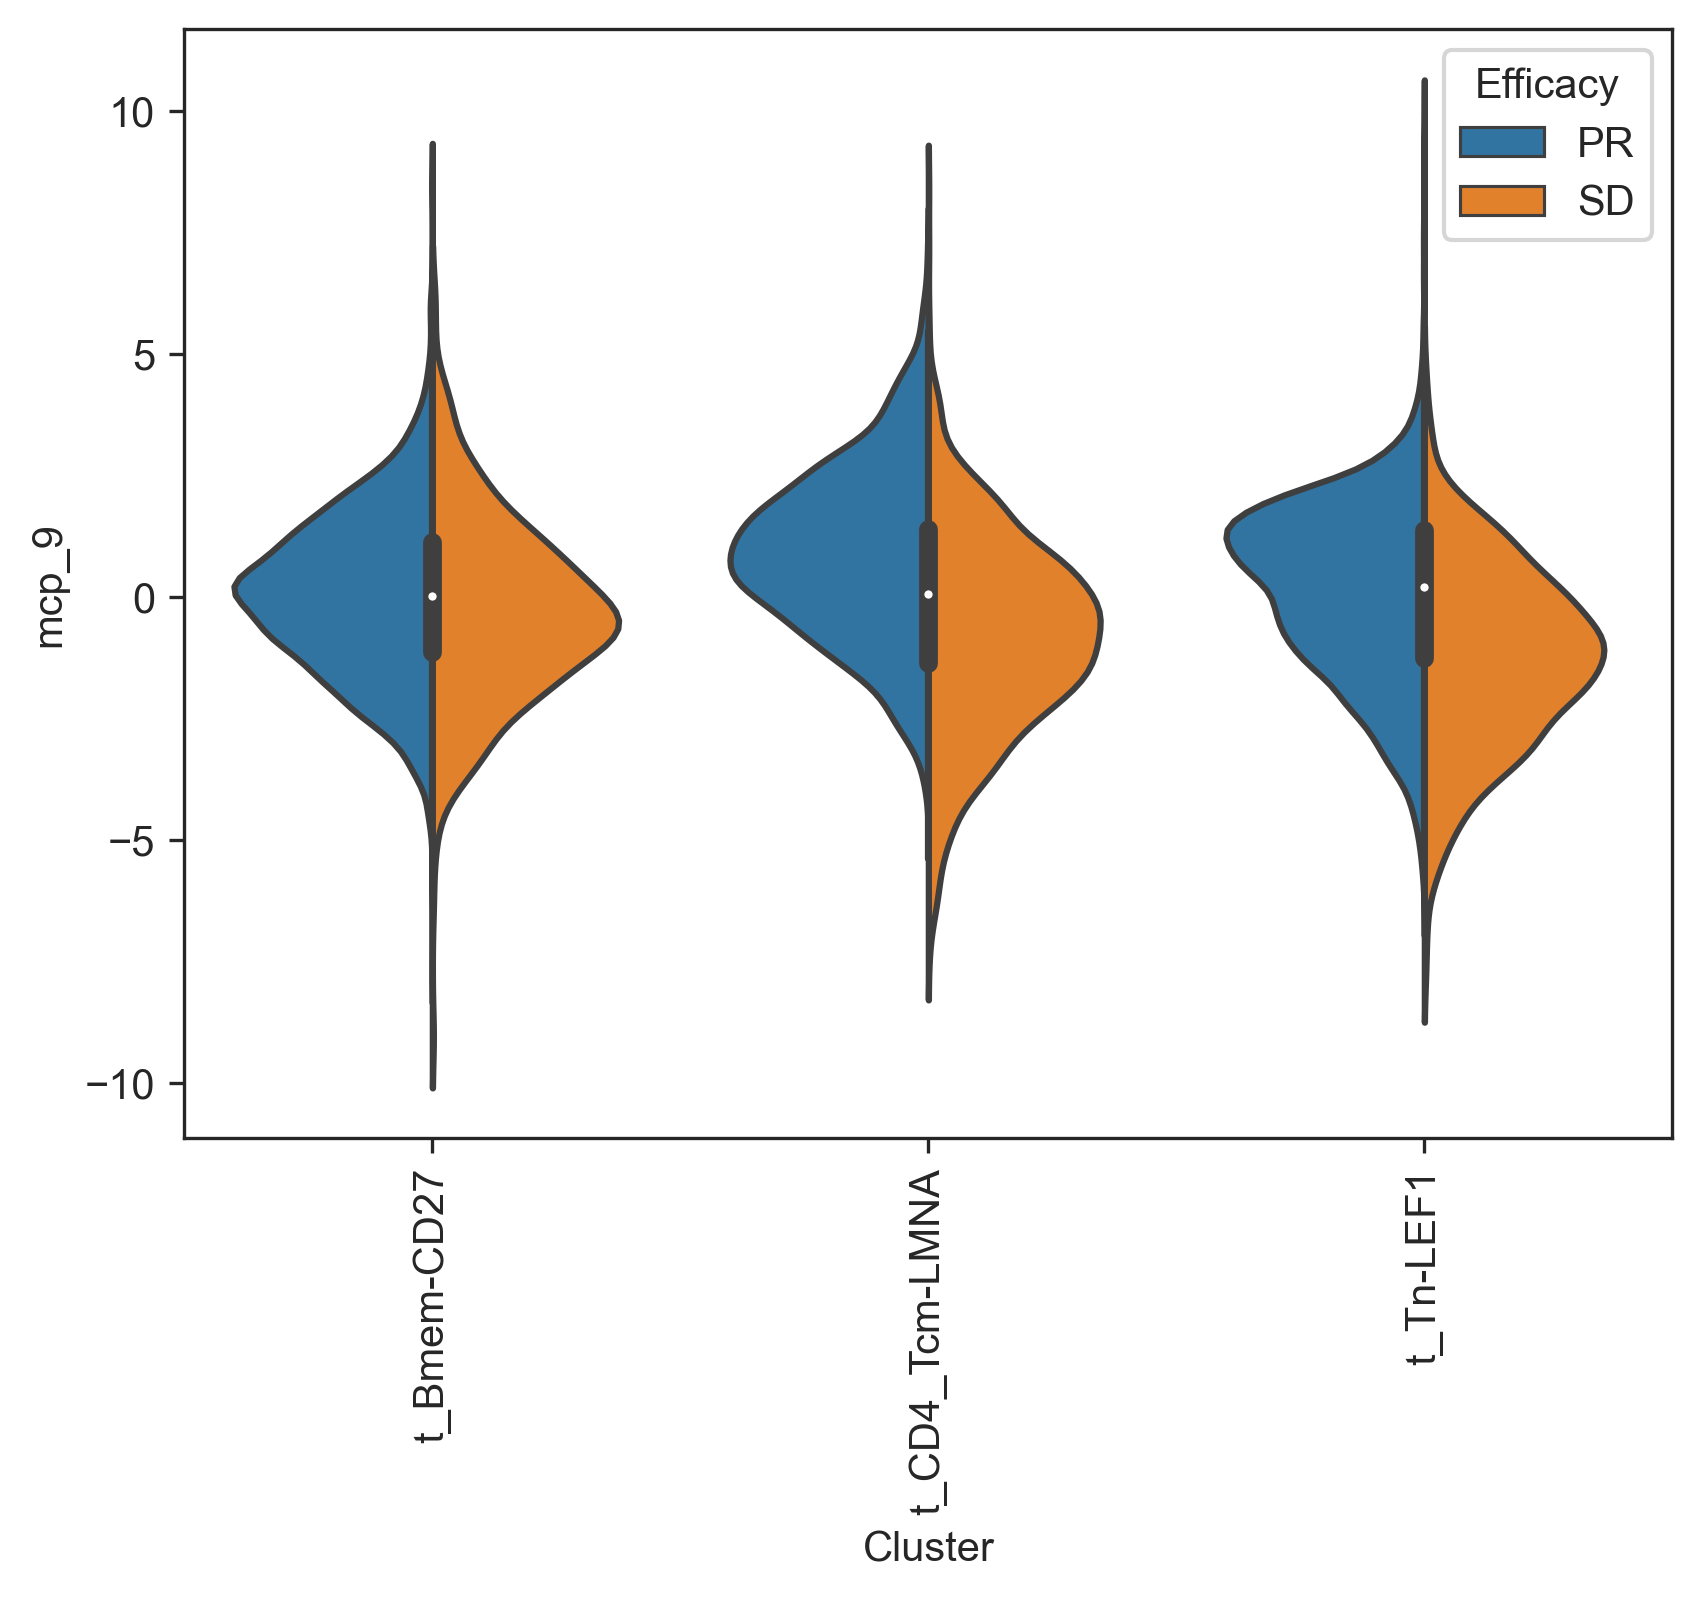

In [11]:
DialoguePlot.split_violins(mini, mcp = "mcp_9",celltype_key = "Cluster", split="Efficacy",show=True, Title = "MCP8 Split Violins")

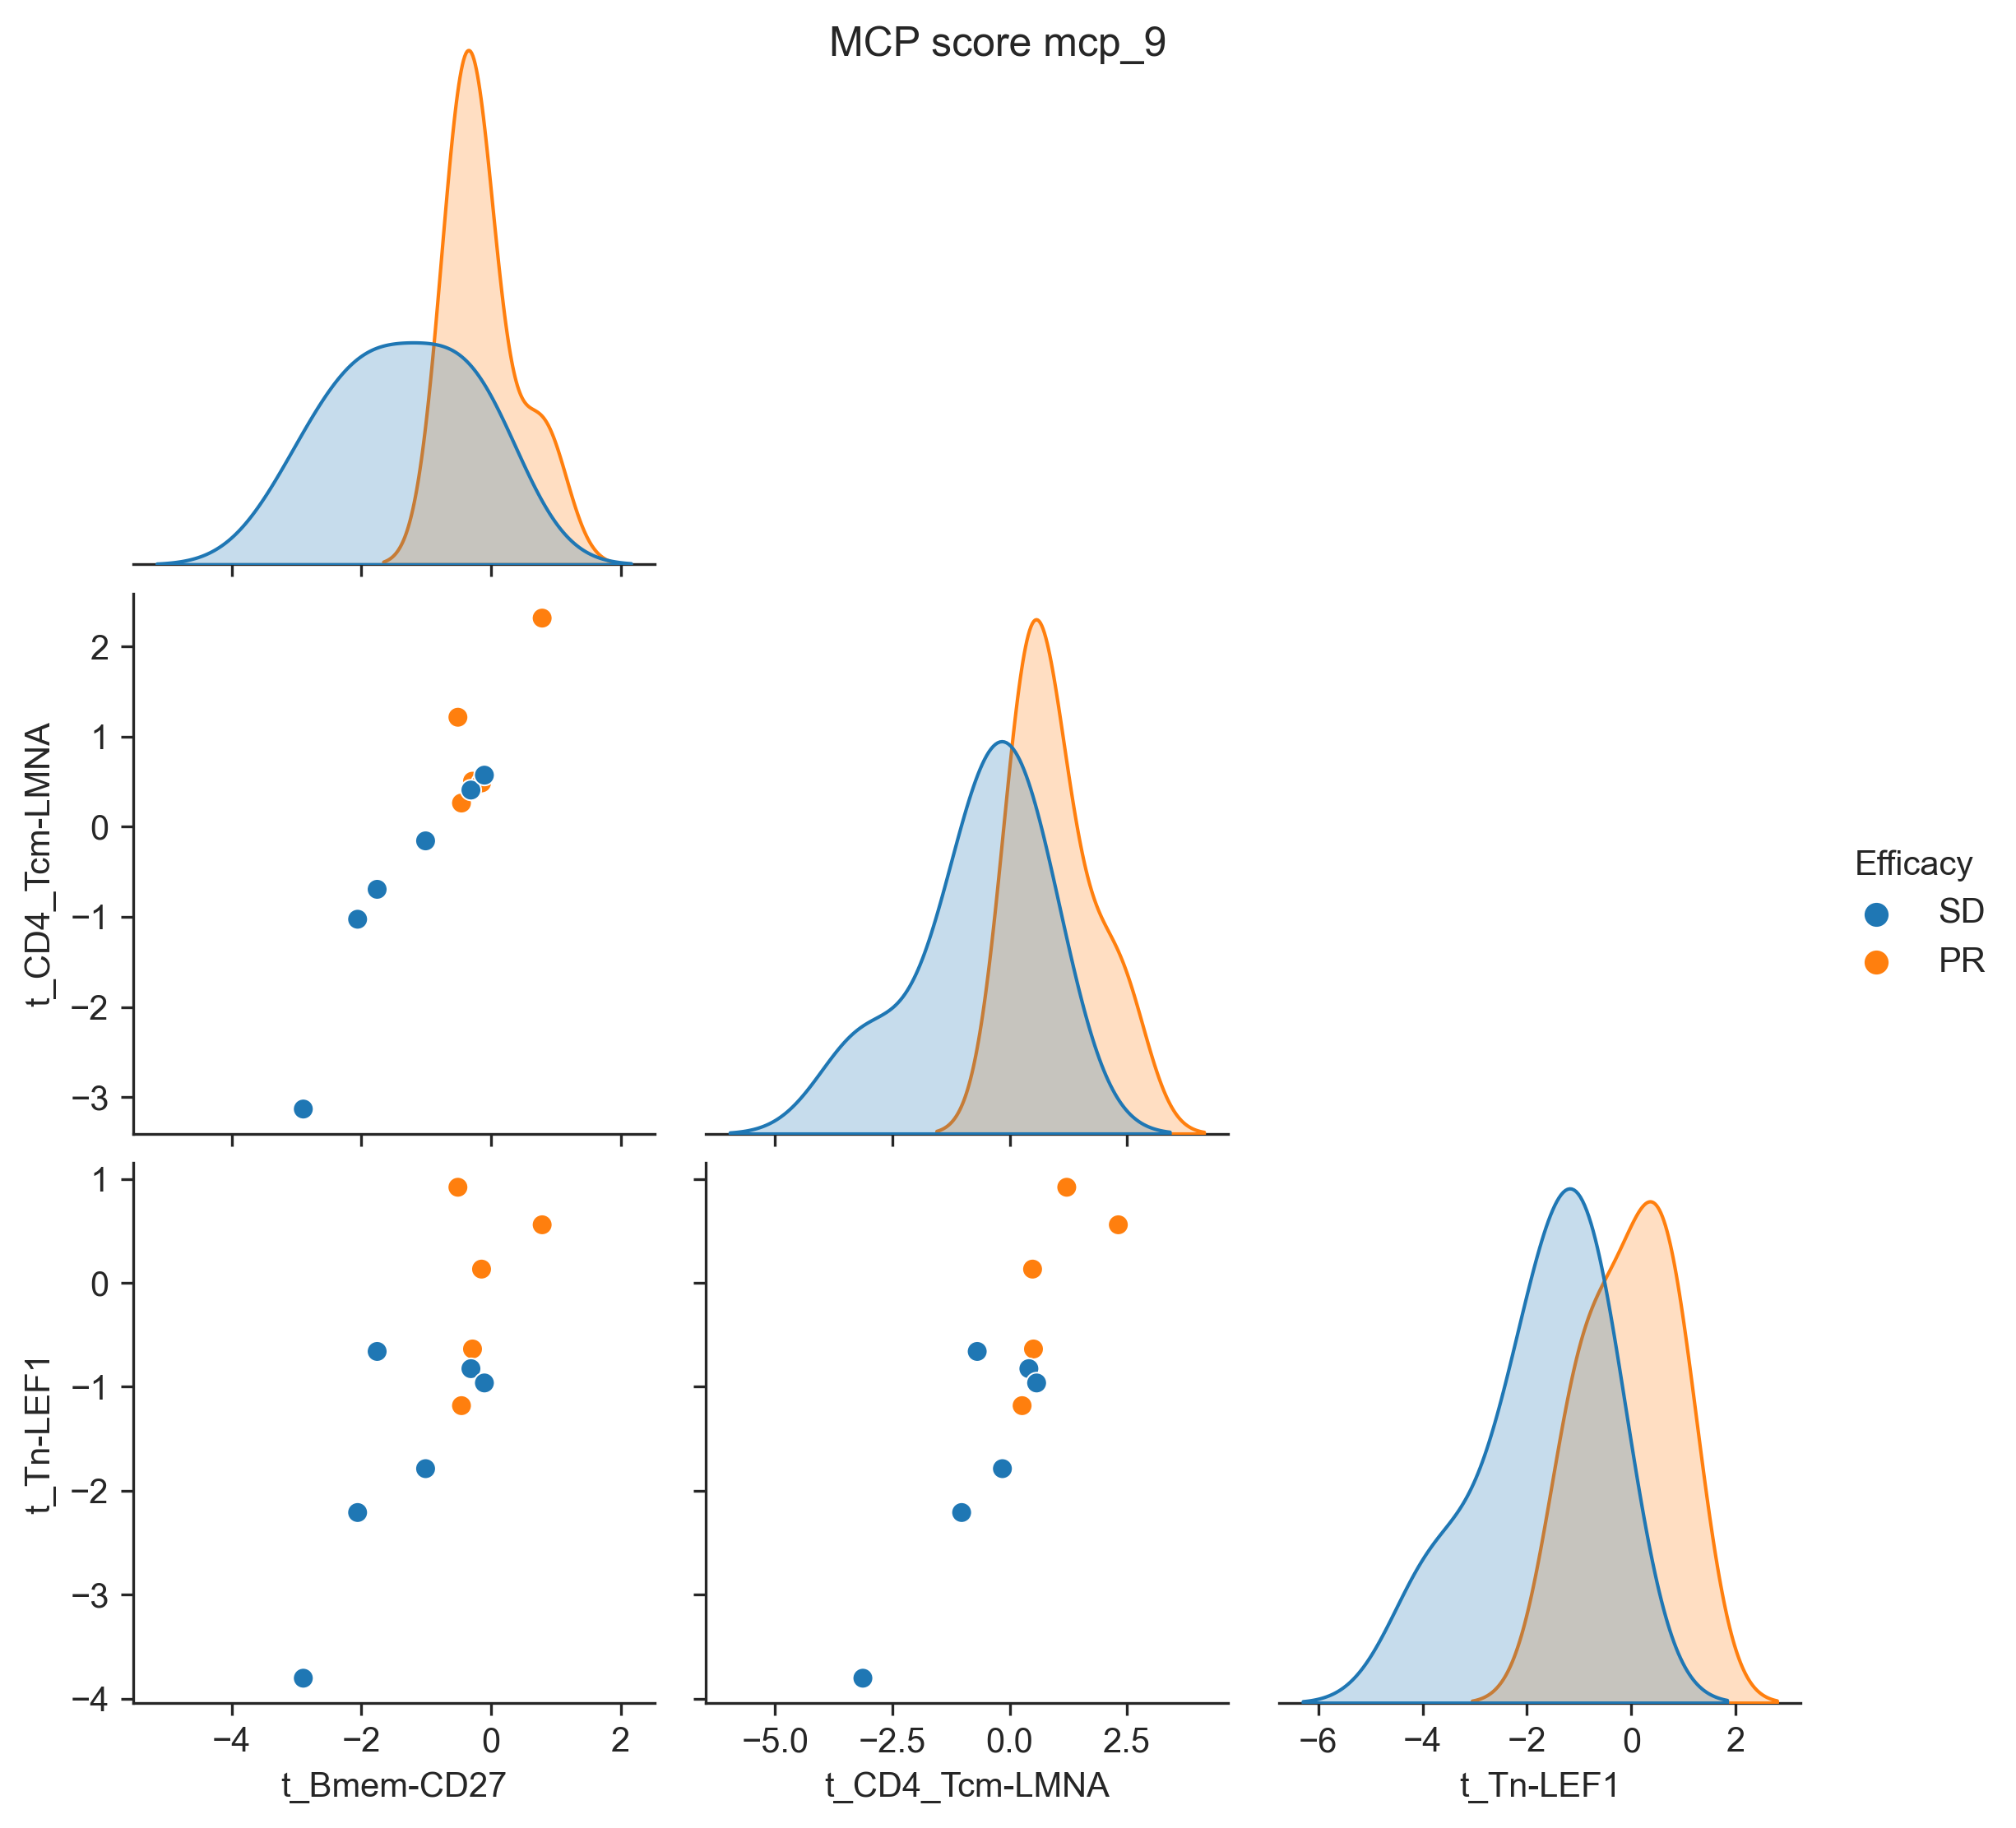

In [12]:
p = DialoguePlot.mcp_pairplot(mini, "Cluster", "Sample", mcp="mcp_9", color = "Efficacy", return_fig=True)

In [13]:
sc.tl.rank_genes_groups(mini, 'mcp_9', method='t-test', key_added = "t-test")
#sc.pl.rank_genes_groups(mini, n_genes=25, sharey=False, key = "t-test")

AttributeError: Can only use .cat accessor with a 'category' dtype

In [63]:
# split mini into the three cell types
# bin high/low
# diffexp for gene lists 

SyntaxError: invalid syntax (442424573.py, line 1)

In [66]:
dl = pt.tl.Dialogue(sample_id = "Sample",
                   celltype_key = "Cluster",
                   n_counts_key = "Number of counts",
                   n_mpcs = 10)

In [94]:
all_results_2, new_mcps_2 = dl.multilevel_modeling(ct_subs=a['ct_subs_2'],
                                     mcp_scores=a['mcps'],
                                     ws_dict=a['ws'],
                                     confounder="Treatment",
                                   )

Output()

10 MCPs identified for t_Bmem-CD27 and t_CD4_Tcm-LMNA.

SyntaxError: invalid syntax (<unknown>, line 1)

In [14]:
ct_subs = a['ct_subs_2']

In [15]:
ct_adata = ct_subs['t_Bmem-CD27']

In [16]:
for ct in ct_subs.keys():
    ct_subs[ct].uns['log1p']["base"] = None
    #ct_subs[ct].X = sparse.csr_matrix(ct_subs[ct].X)

In [17]:
def get_genes(ct_subs, mcp="mcp_9"):
    genes=dict()
    for ct in ct_subs.keys():
        mini = ct_subs[ct]
        mini.obs['mcp_9']
        mini.obs['extrema'] =pd.qcut(mini.obs['mcp_9'],[0,0.25,0.75,1.0], labels = ["low "+mcp+" "+ct,"no","high"+mcp+" "+ct])
        sc.tl.rank_genes_groups(mini,"extrema", groups = ["high"+mcp+" "+ct],reference="low "+mcp+" "+ct)
        genes[ct] = mini#.uns['rank_genes_groups']
    return genes

In [18]:
a = get_genes(ct_subs)

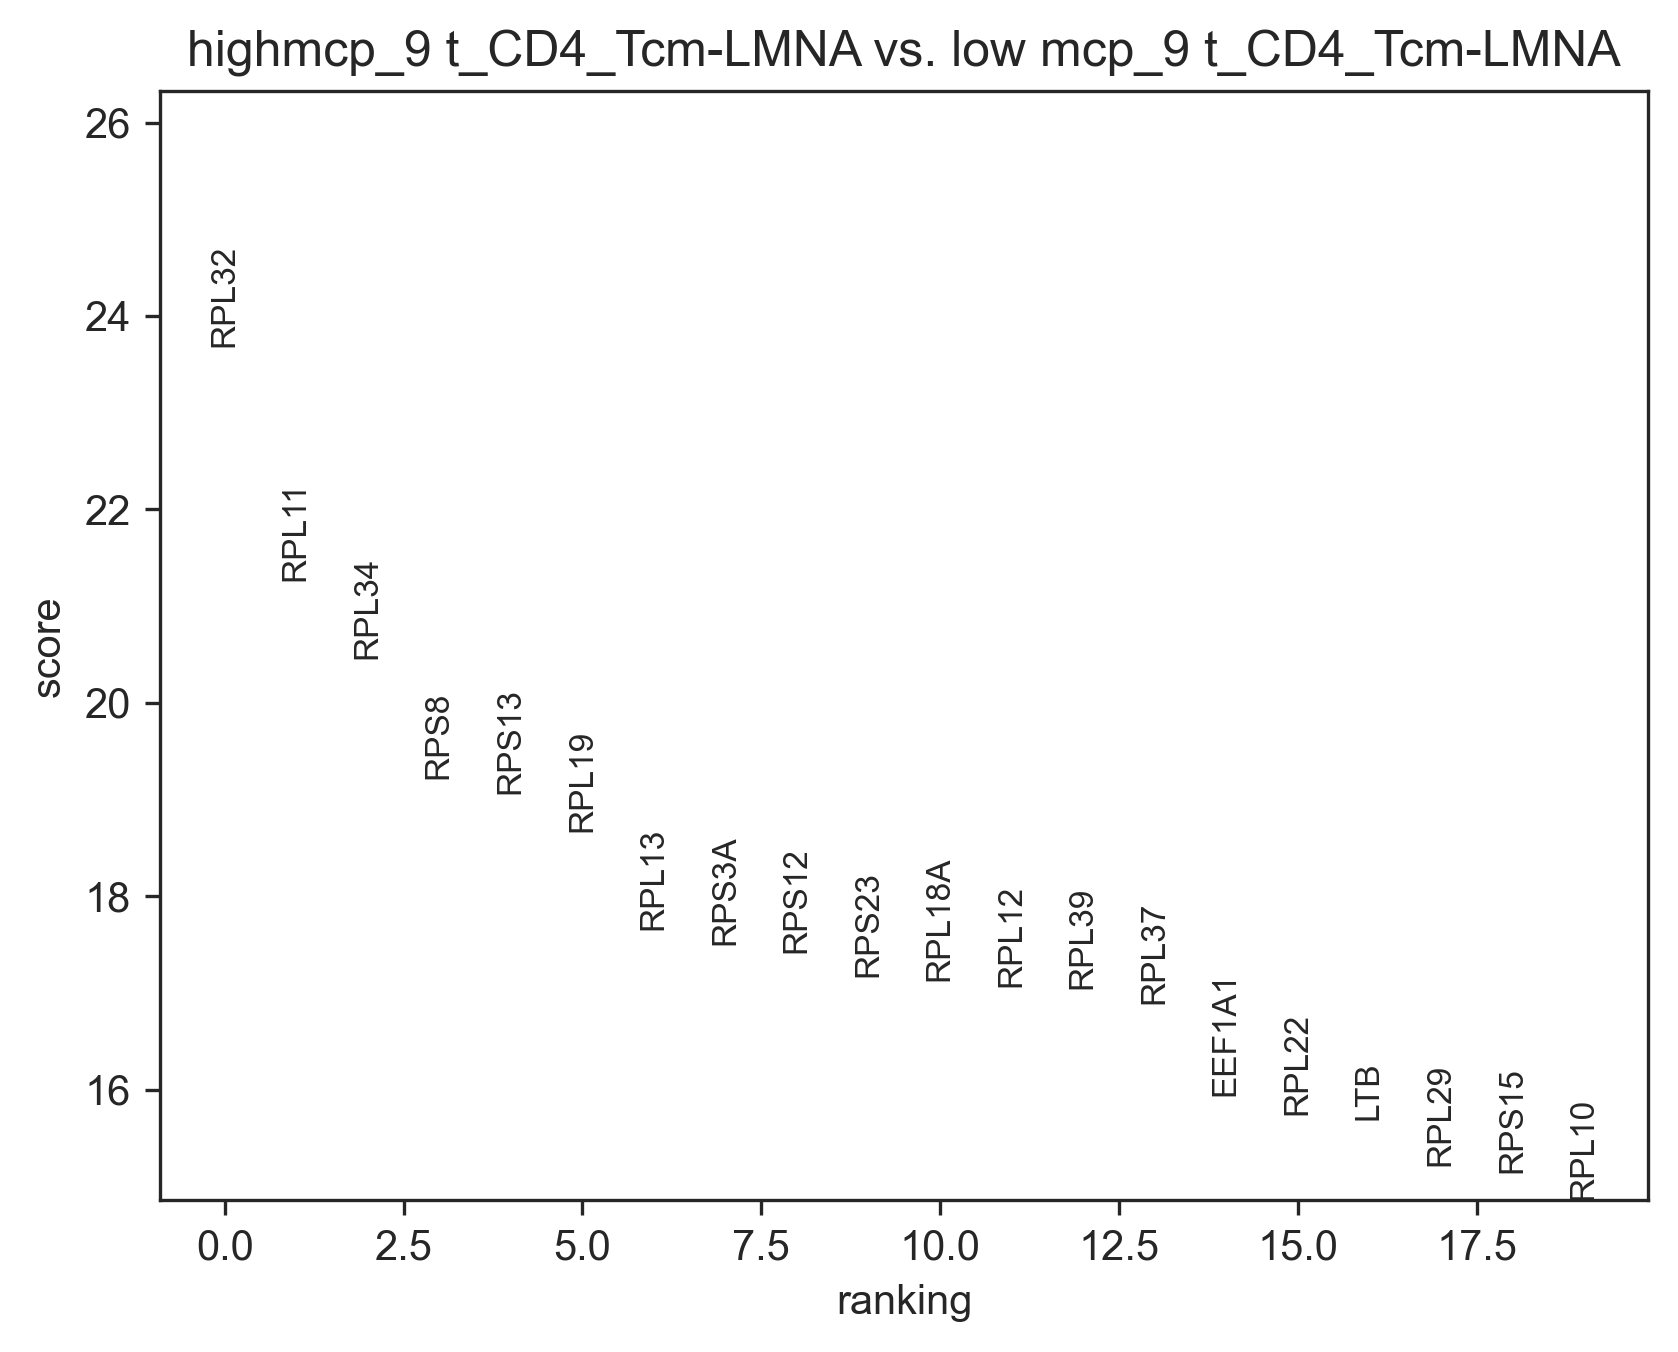

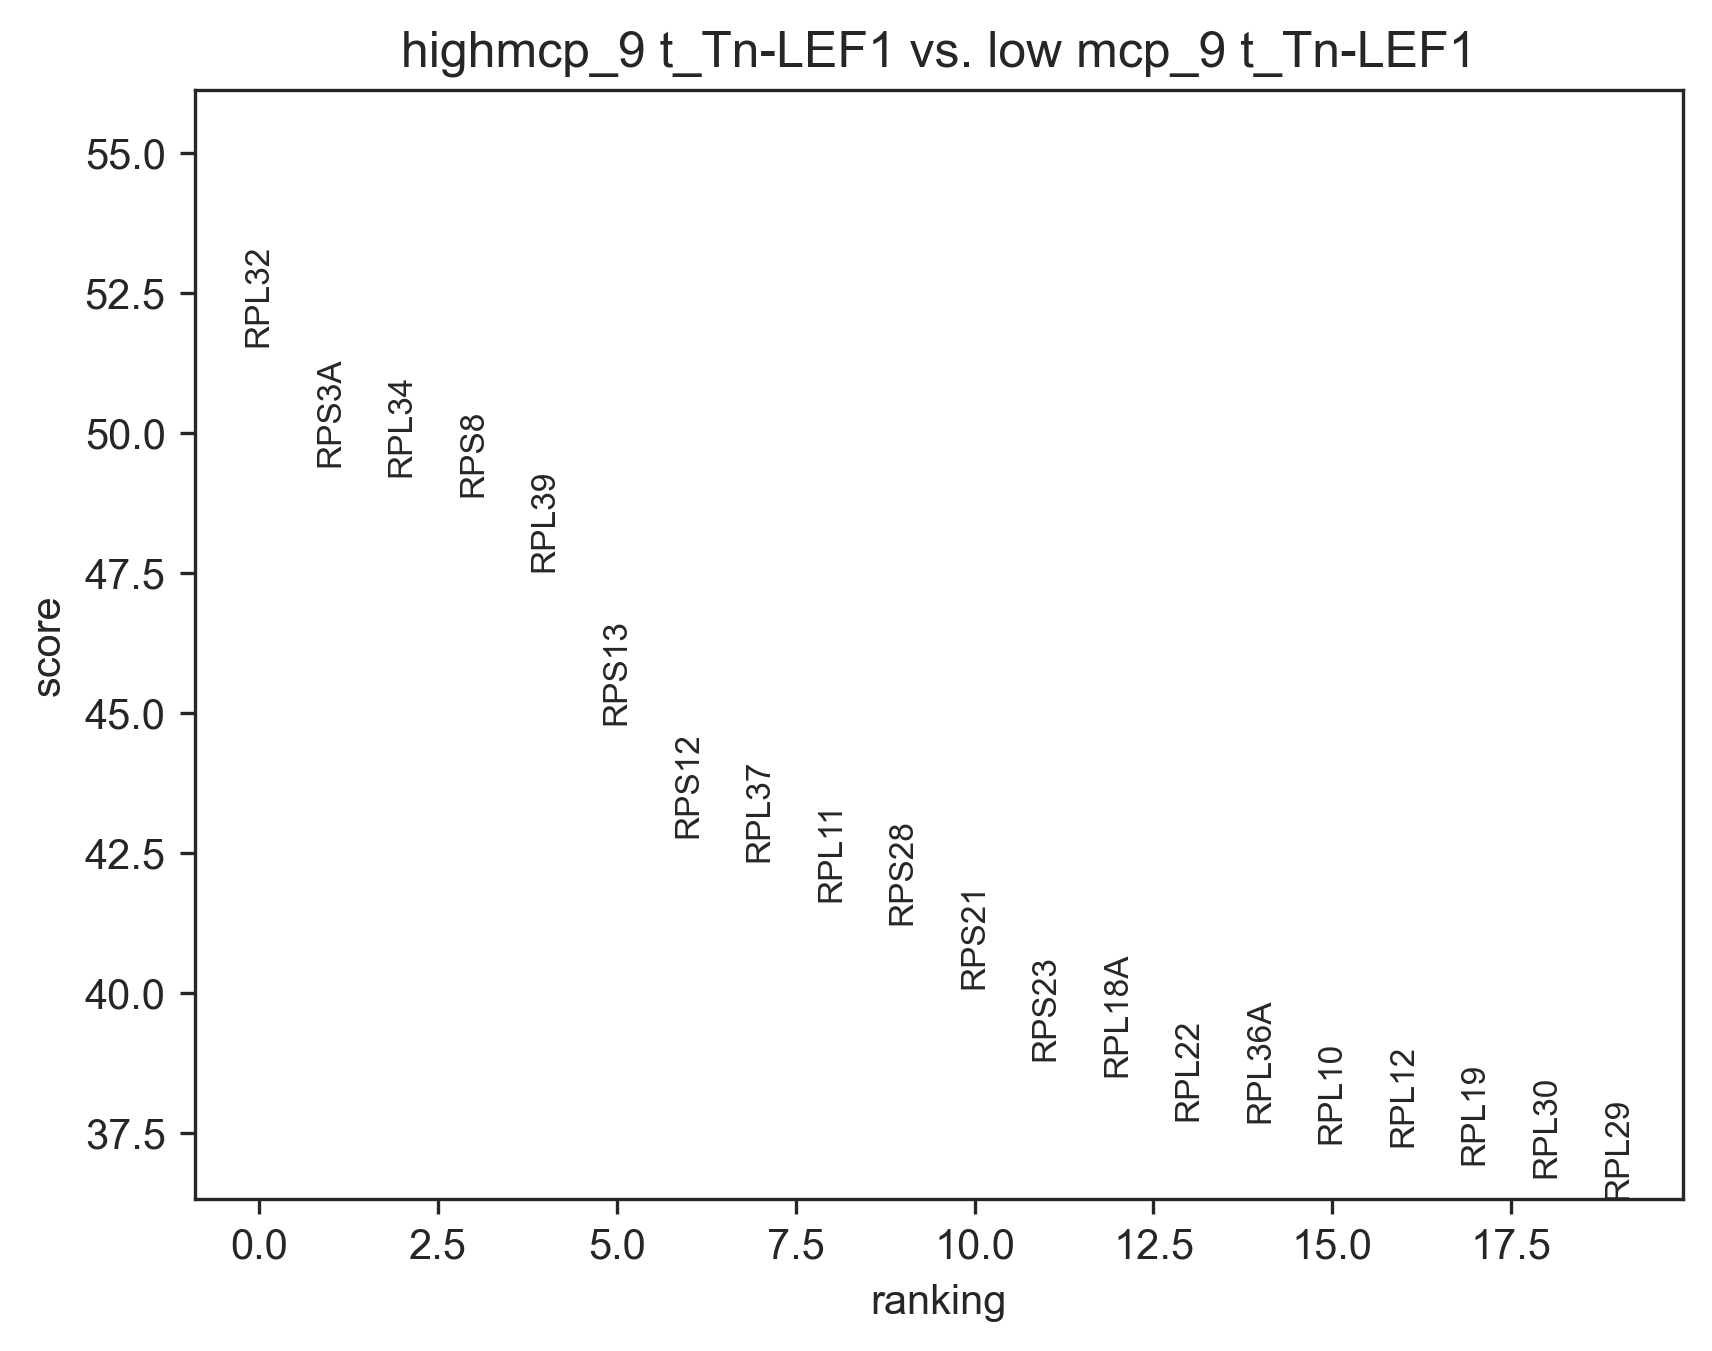

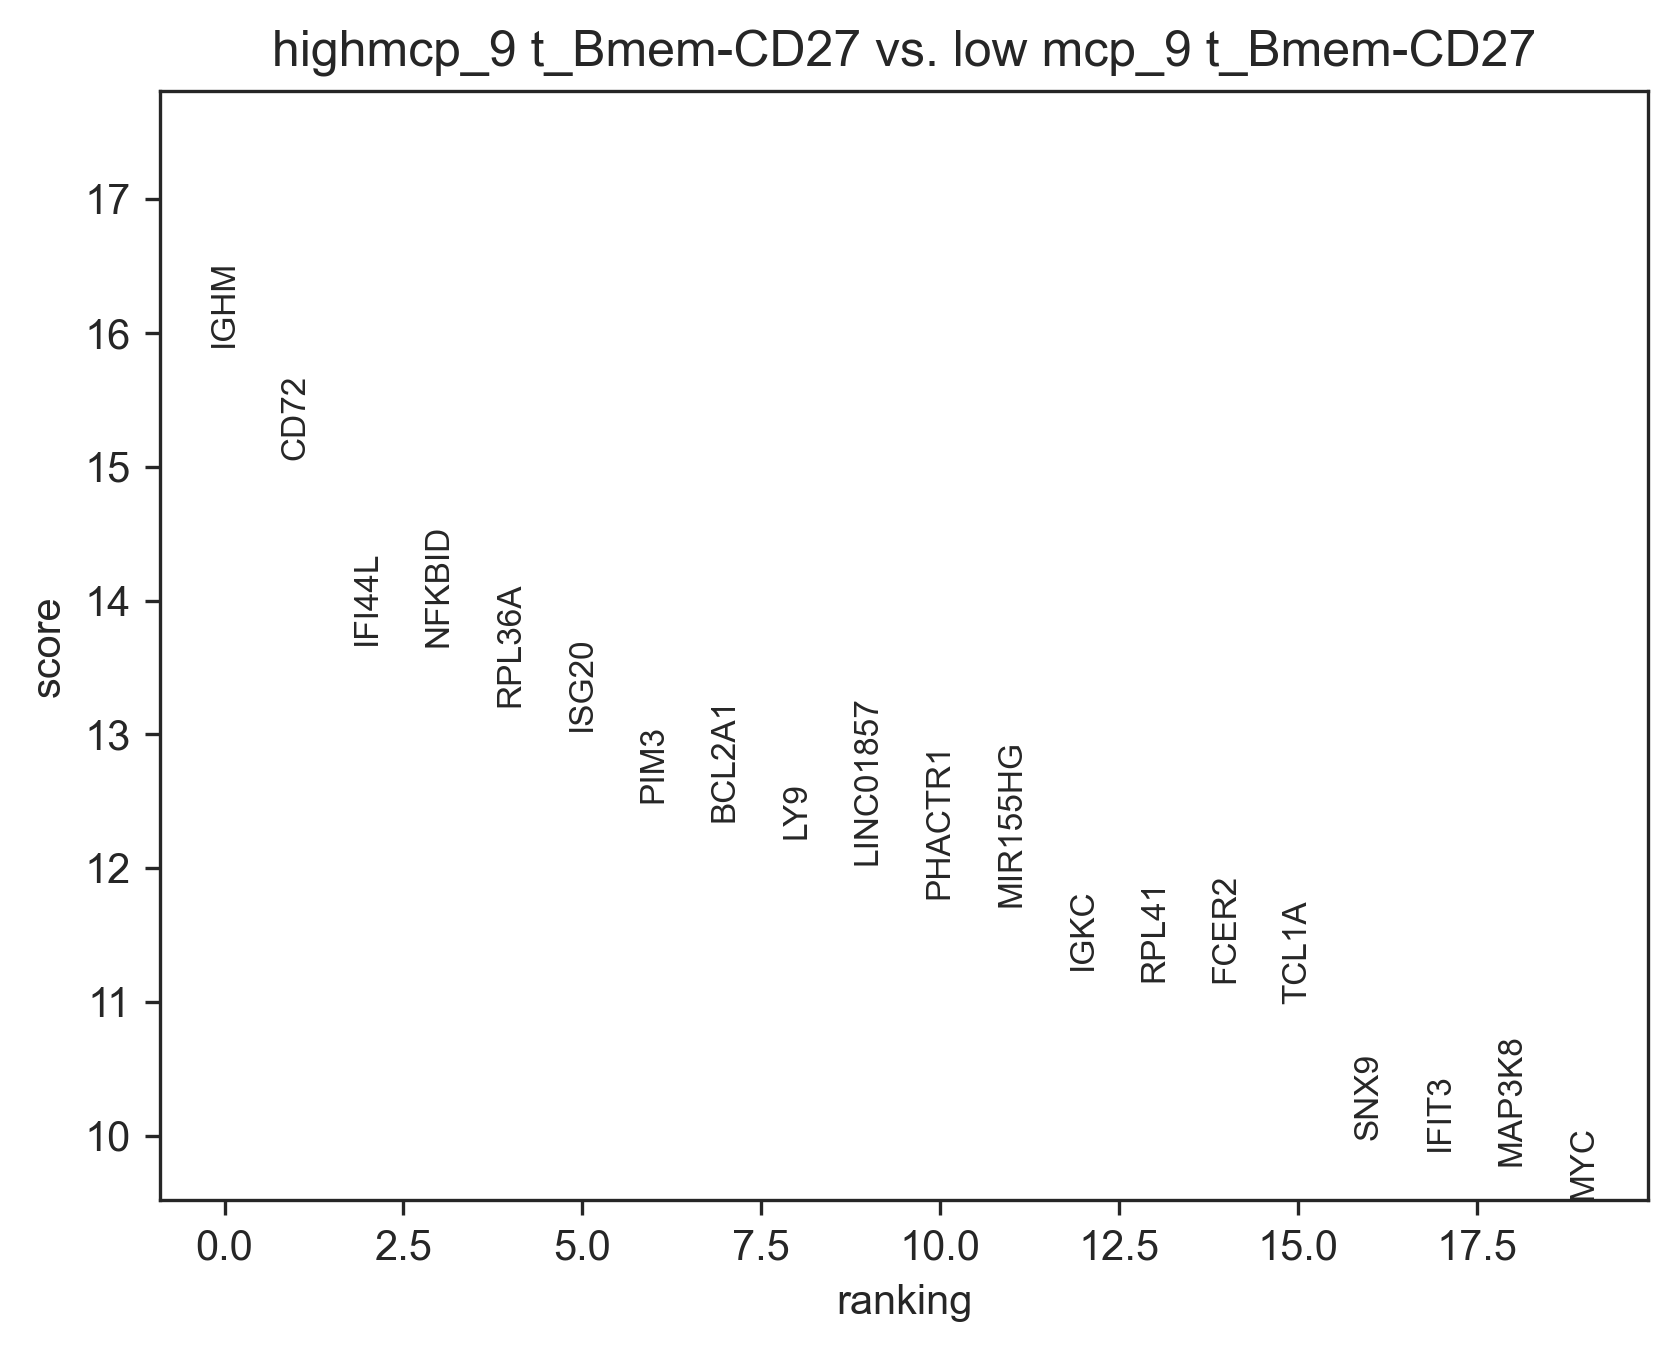

In [19]:
sc.pl.rank_genes_groups(a['t_CD4_Tcm-LMNA'])
sc.pl.rank_genes_groups(a['t_Tn-LEF1'])
sc.pl.rank_genes_groups(a['t_Bmem-CD27'])

# sc.pl.rank_genes_groups_dotplot(a['t_Bmem-CD27'])


In [20]:
a.keys()


dict_keys(['t_Bmem-CD27', 't_CD4_Tcm-LMNA', 't_CD4_Treg-FOXP3', 't_CD8_MAIT-KLRB1', 't_CD8_Tem-GZMK', 't_CD8_Trm-ZNF683', 't_Tn-LEF1', 't_mono-FCN1', 't_pB-IGHG1'])

In [21]:
ct_subs['t_Bmem-CD27'].obs['Cluster']

Cell barcode
AAATGCCTCATCTGCC.Pre_P007_t    t_Bmem-CD27
AATCCAGAGCGTTCCG.Pre_P007_t    t_Bmem-CD27
ACAGCCGAGCACCGCT.Pre_P007_t    t_Bmem-CD27
ACCGTAAAGCTAACTC.Pre_P007_t    t_Bmem-CD27
ACGAGCCTCGTAGGTT.Pre_P007_t    t_Bmem-CD27
                                  ...     
CTGATAGTCAGGCAAG.Pre_P004_t    t_Bmem-CD27
CTTAACTCAGTAAGCG.Pre_P004_t    t_Bmem-CD27
GCACATATCTGTTTGT.Pre_P004_t    t_Bmem-CD27
TCATTTGCACGCTTTC.Pre_P004_t    t_Bmem-CD27
TCGTAGATCCCTAATT.Pre_P004_t    t_Bmem-CD27
Name: Cluster, Length: 7283, dtype: category
Categories (1, object): ['t_Bmem-CD27']

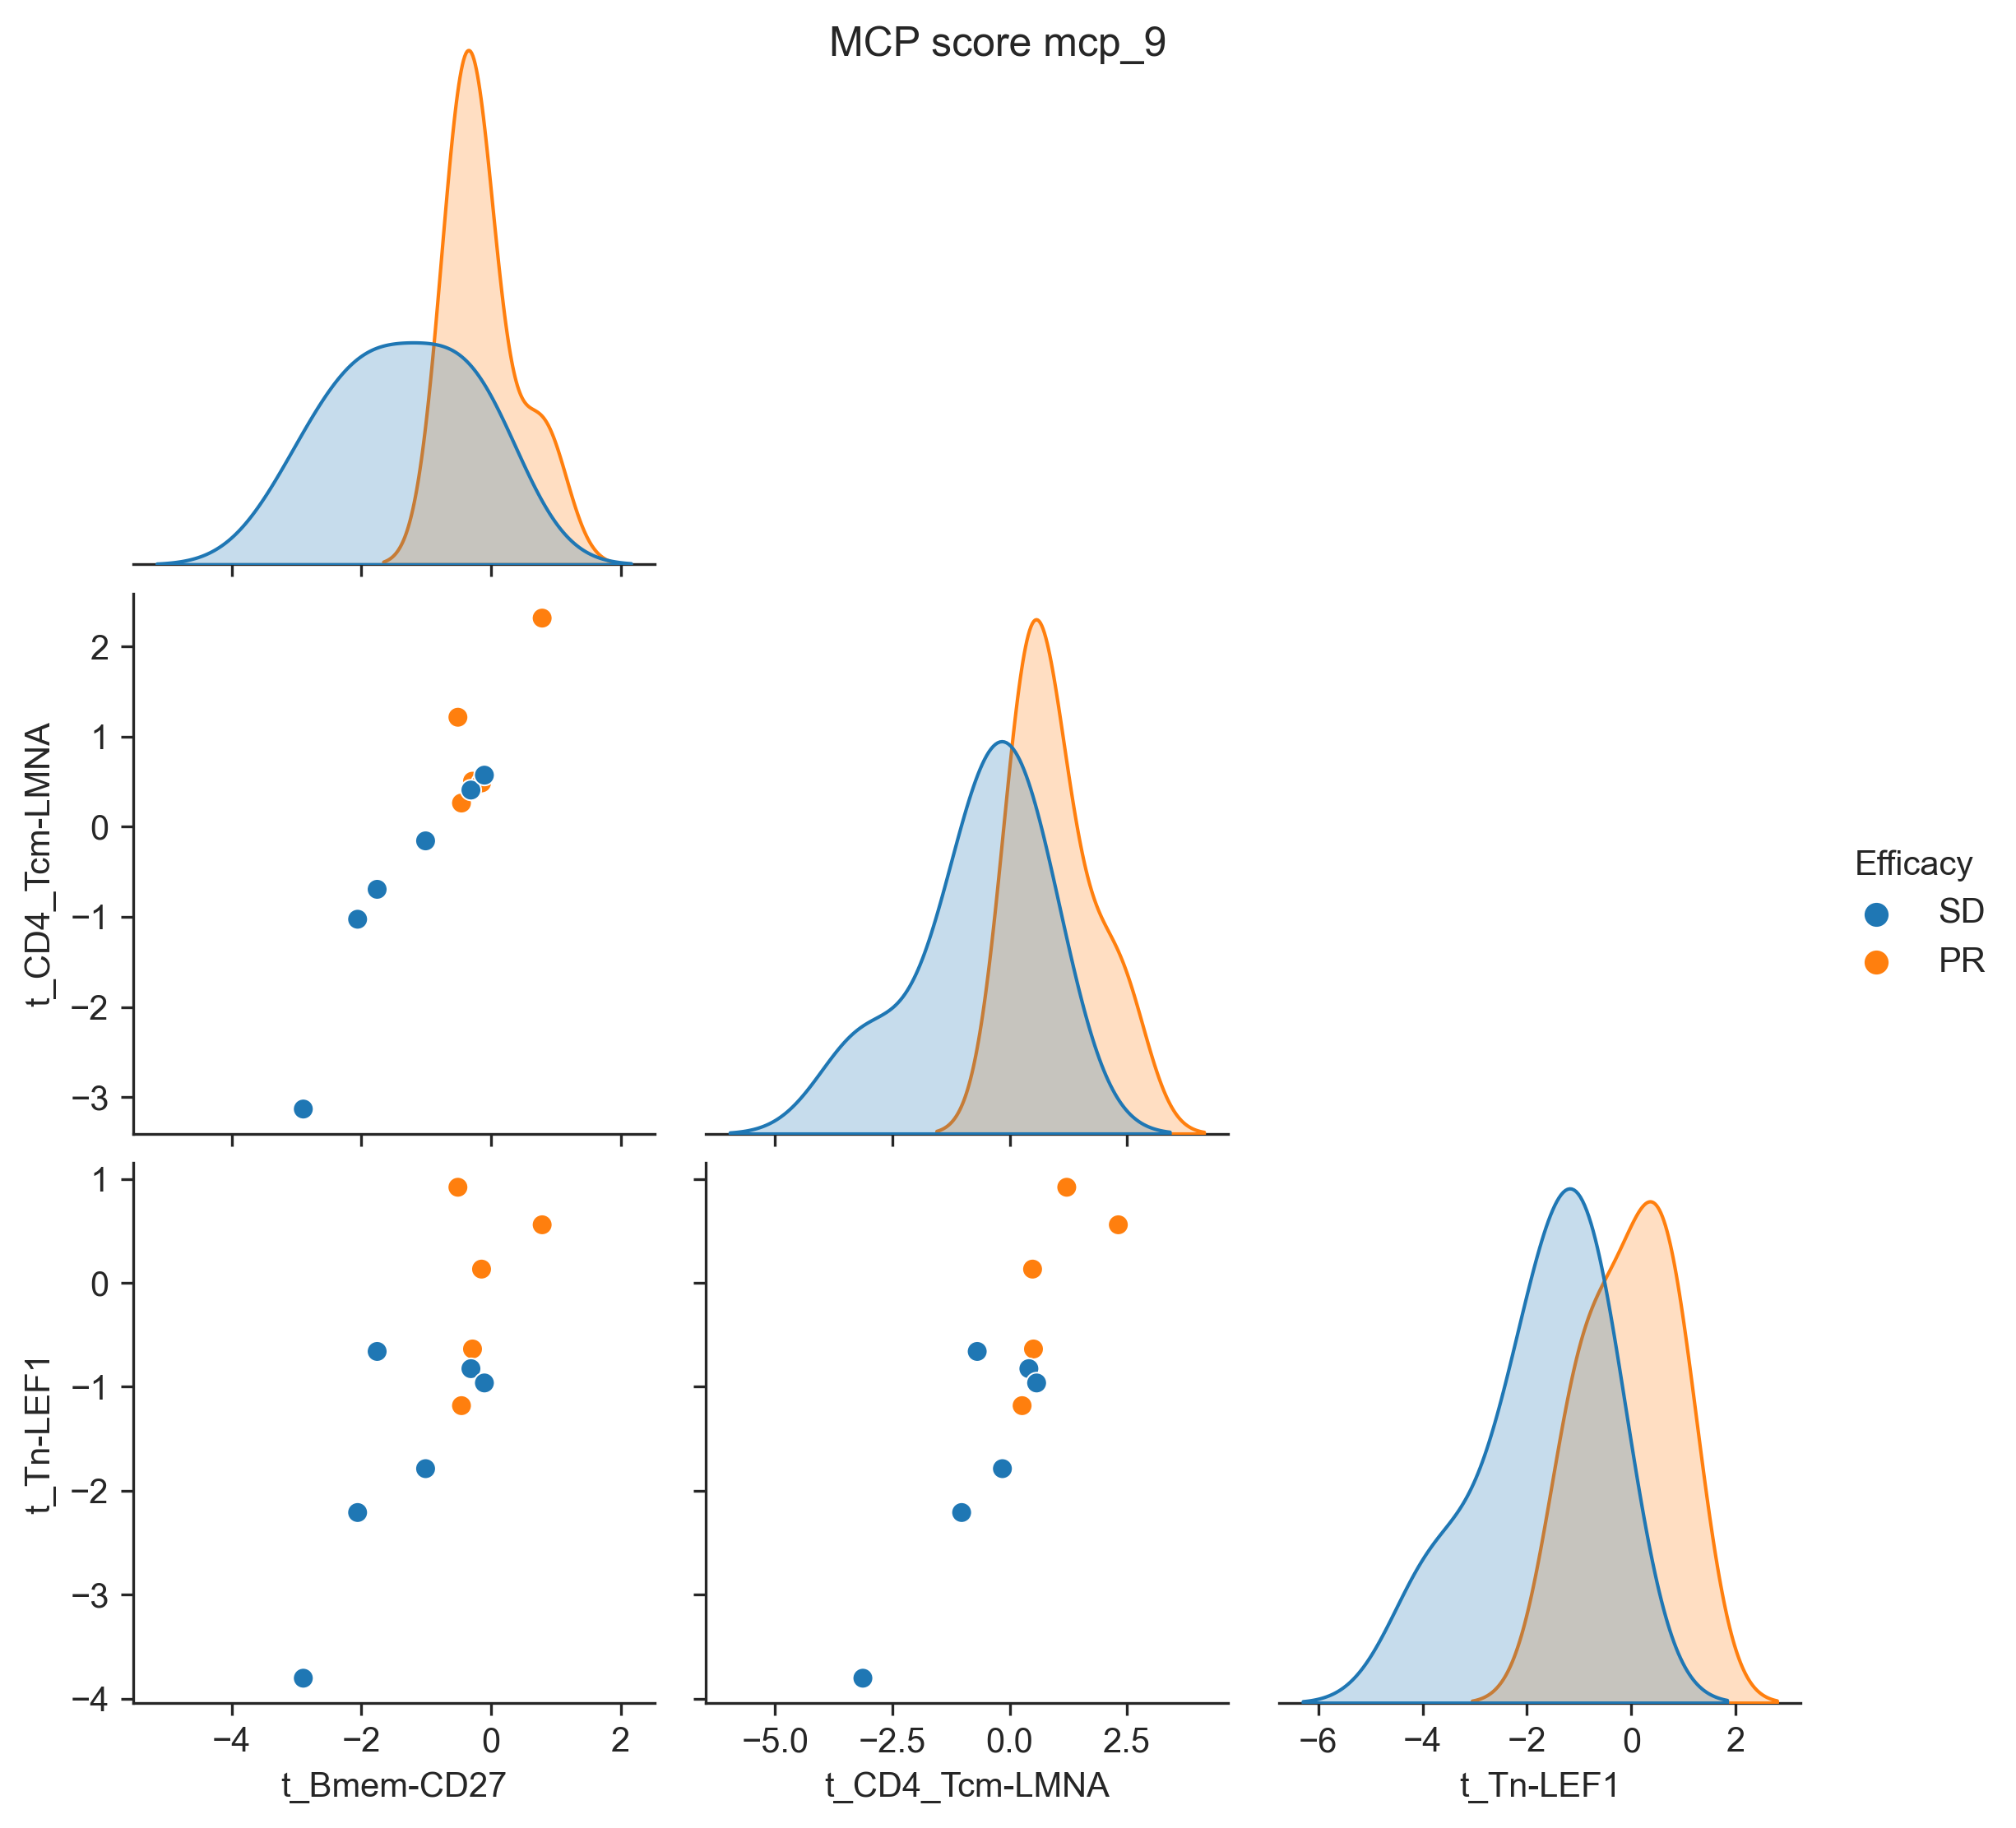

In [22]:
p = DialoguePlot.mcp_pairplot(mini, "Cluster", "Sample", mcp="mcp_9", color = "Efficacy", return_fig=True)

#for t, l in zip(legend.texts,("Male", "Female")):
#    t.set_text(l)

In [55]:
mini.obs['Efficacy']==

Cell barcode
AAATGCCTCATCTGCC.Pre_P007_t    PR
AATCCAGAGCGTTCCG.Pre_P007_t    PR
ACAGCCGAGCACCGCT.Pre_P007_t    PR
ACCGTAAAGCTAACTC.Pre_P007_t    PR
ACGAGCCTCGTAGGTT.Pre_P007_t    PR
                               ..
TGTATTCAGTACGTAA.Pre_P004_t    SD
TGTTCCGGTAATCACC.Pre_P004_t    SD
TTGCGTCCATGCCACG.Pre_P004_t    SD
TTTATGCTCCAAACAC.Pre_P004_t    SD
TTTGTCATCCGAAGAG.Pre_P004_t    SD
Name: Efficacy, Length: 22515, dtype: category
Categories (2, object): ['PR', 'SD']

In [57]:
mini.obs['Efficacy']= mini.obs['Efficacy'].cat.rename_categories({'PR': 'Partial response',  'SD': "Stable disease"})


In [59]:
mini.obs['Cluster']= mini.obs['Cluster'].cat.rename_categories({'t_Bmem-CD27': "Memory B cells", 't_Tn-LEF1':"Naive T cells",'t_CD4_Tcm-LMNA' :'CD4 Central memory T cells'})

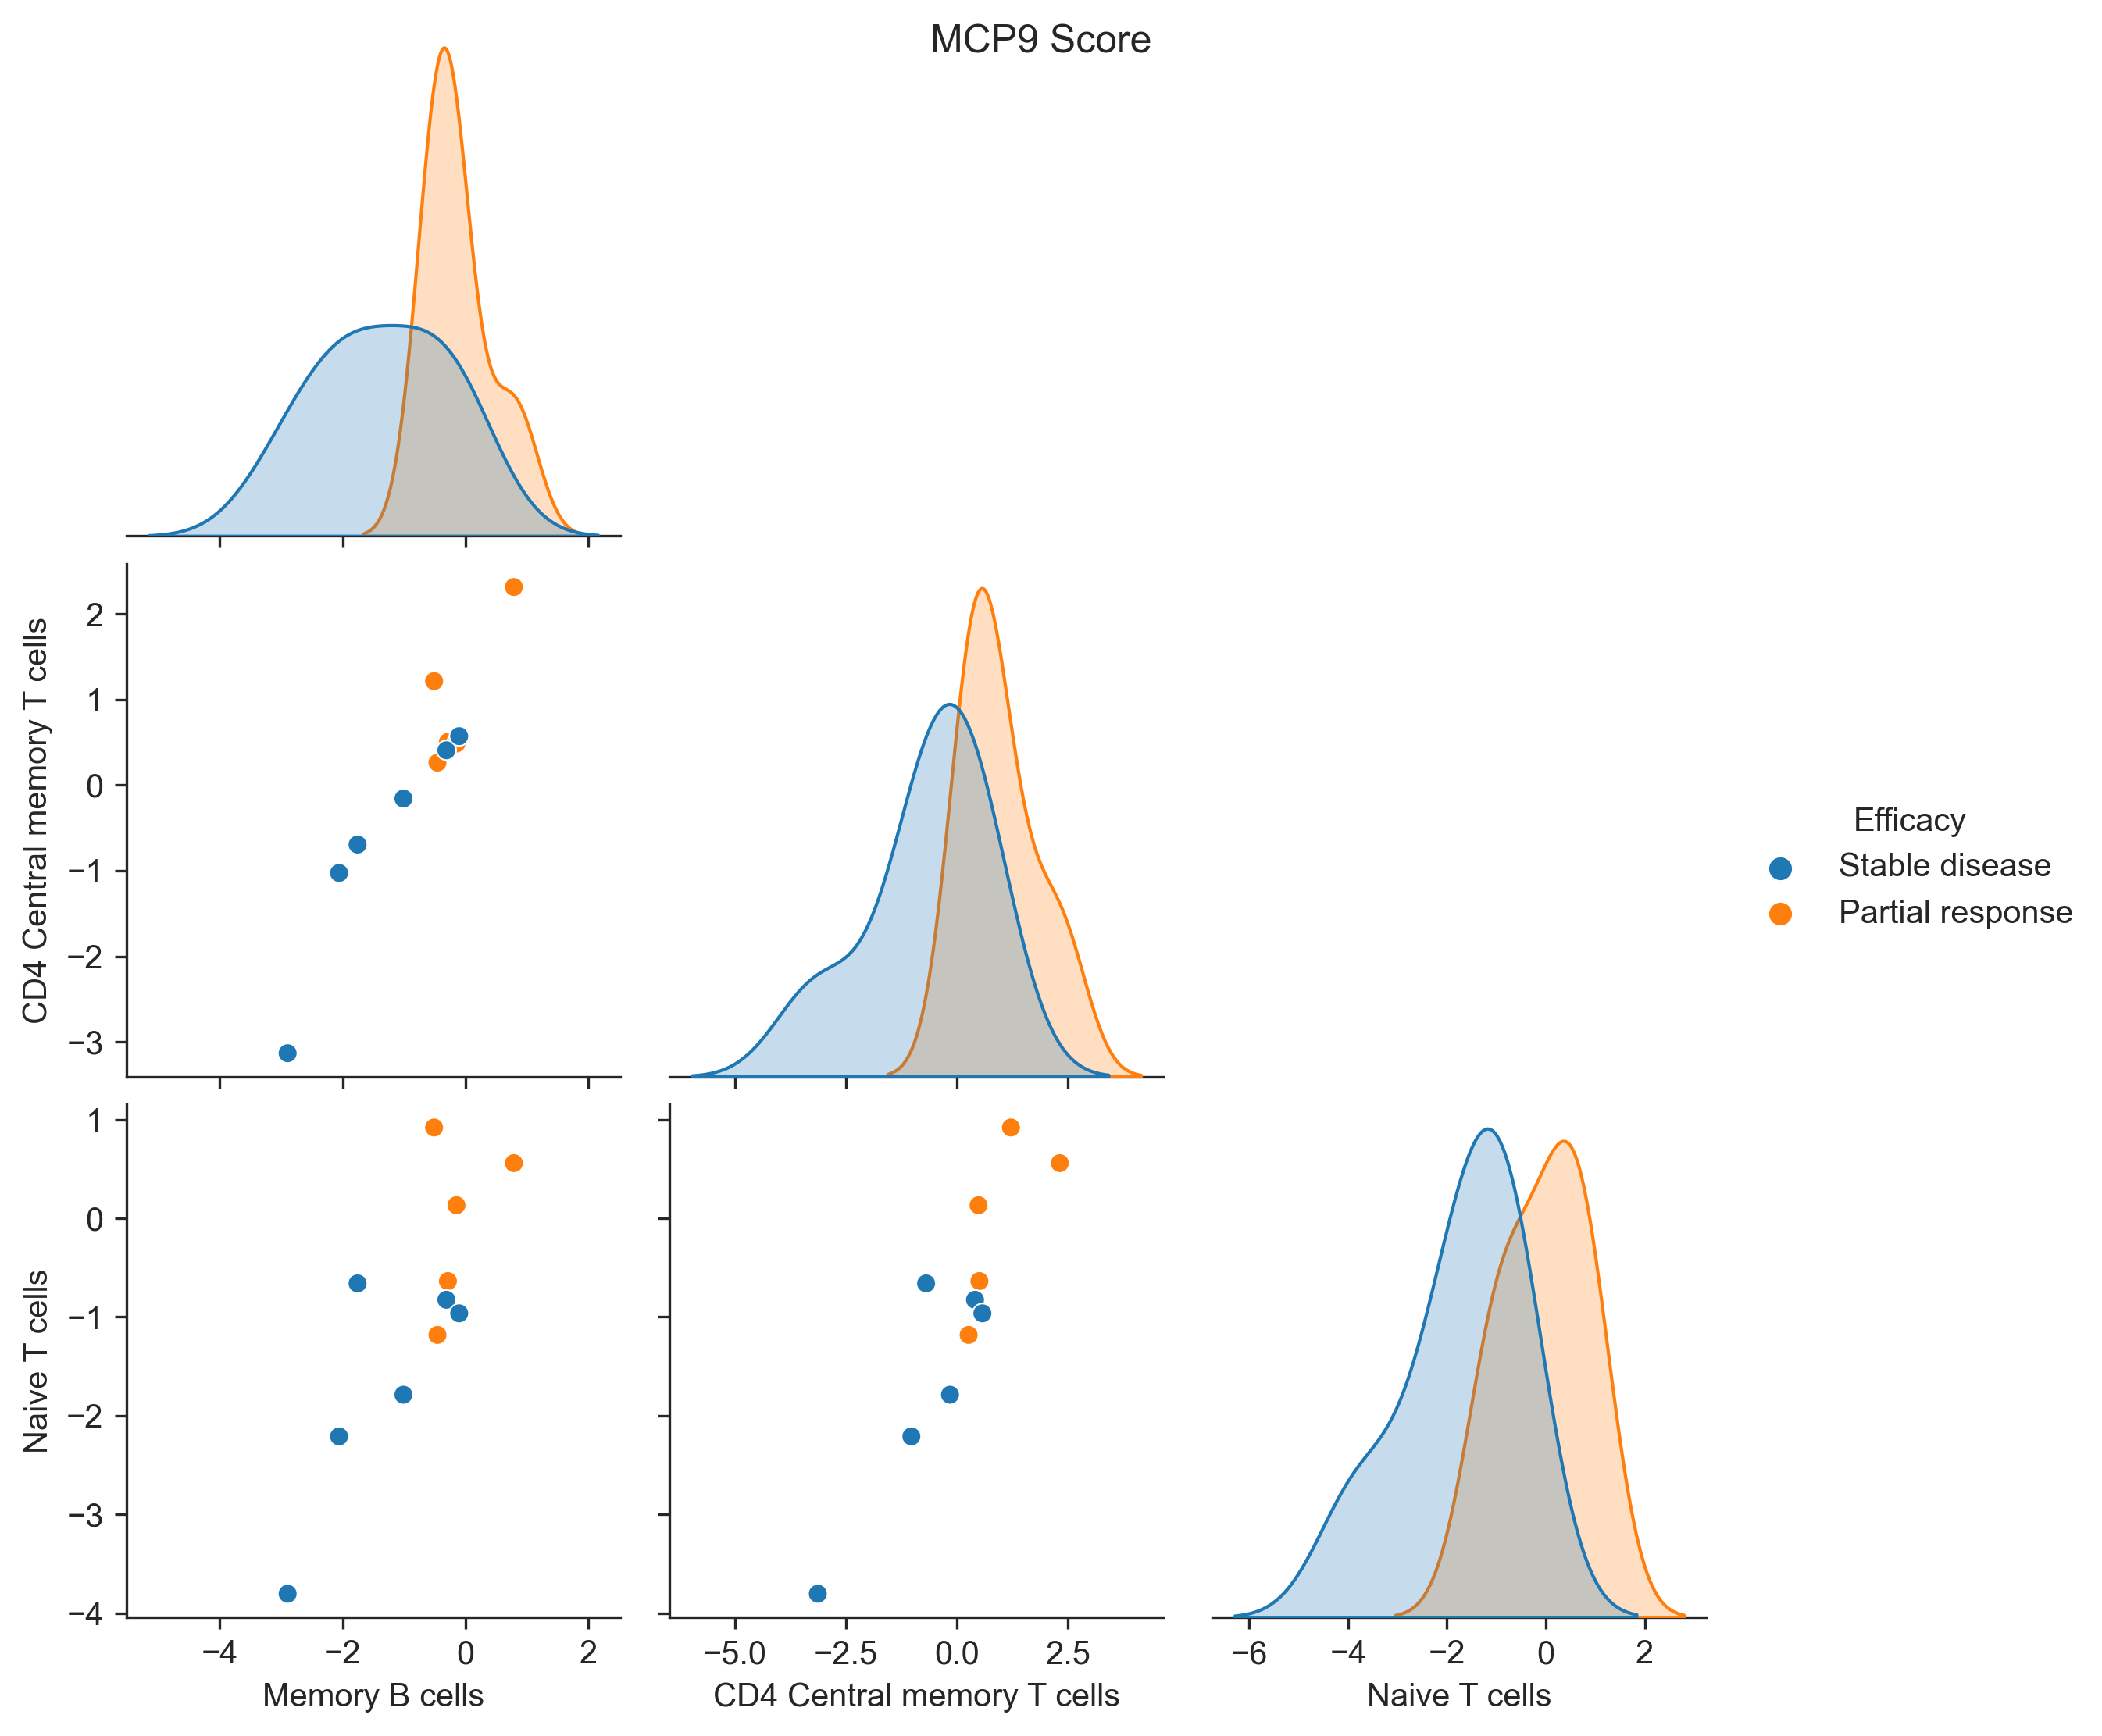

In [61]:
DialoguePlot.mcp_pairplot(mini, "Cluster", "Sample", mcp="mcp_9", color = "Efficacy", return_fig=True, title = "MCP9 Score")


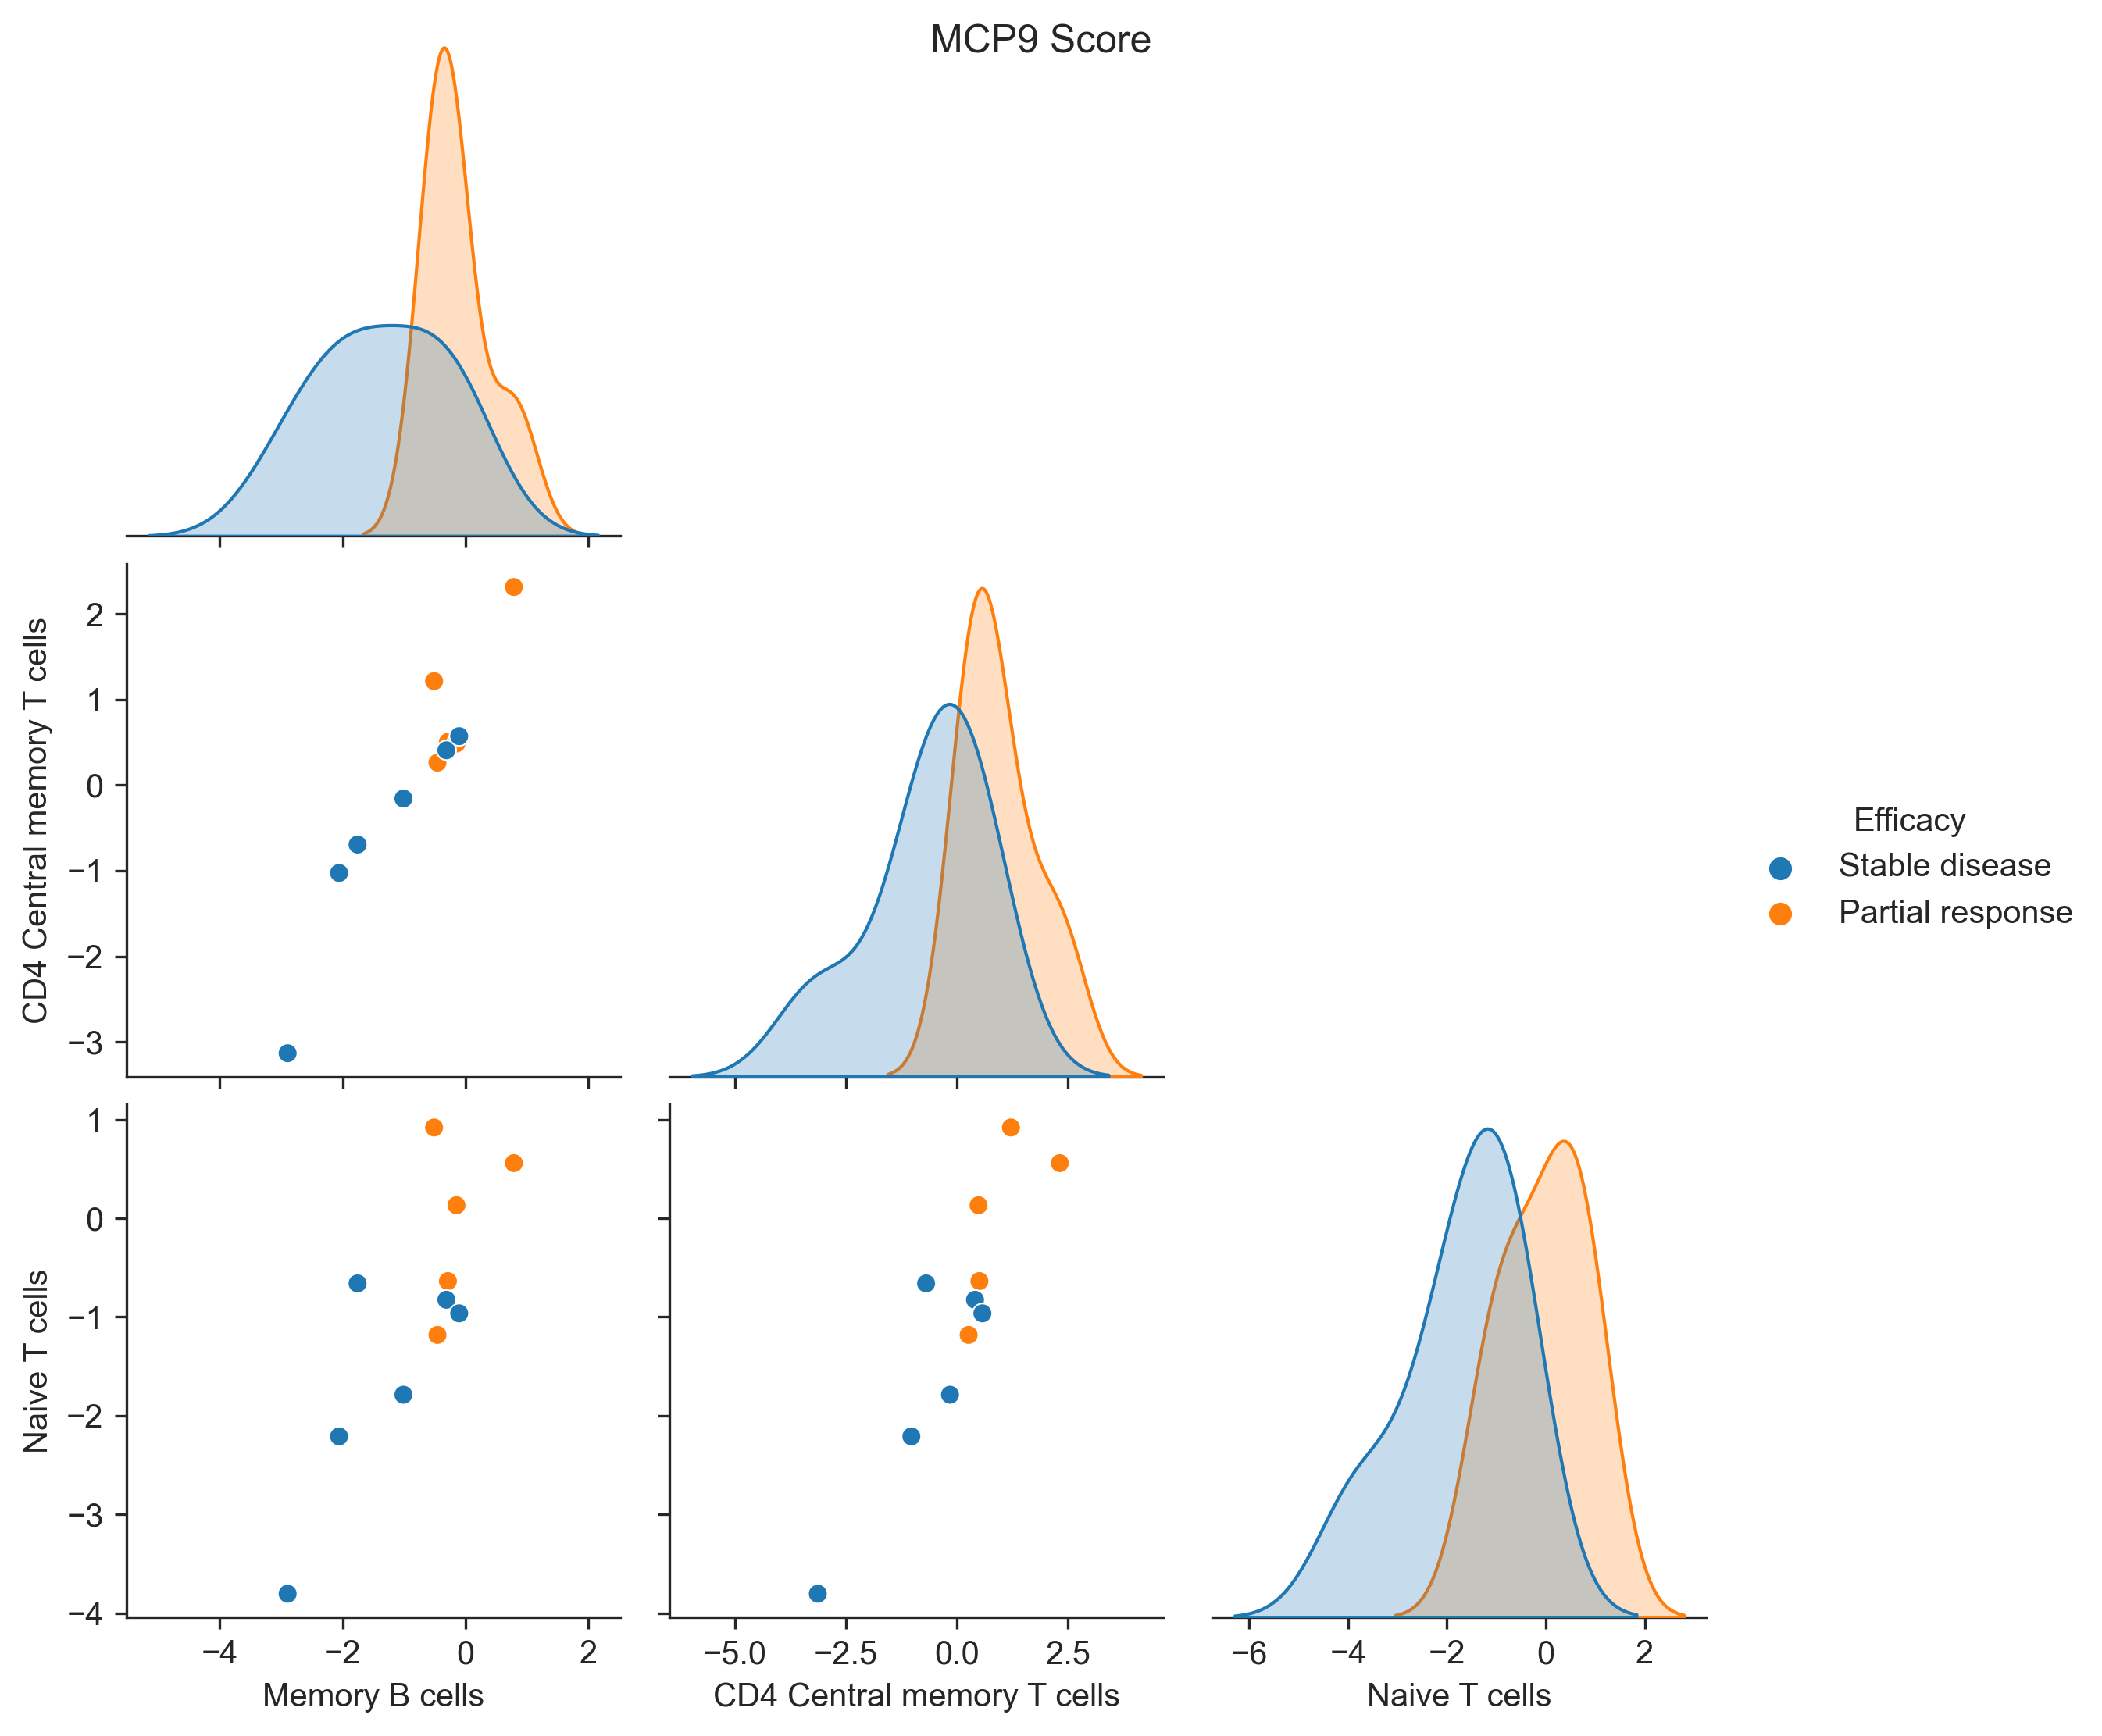

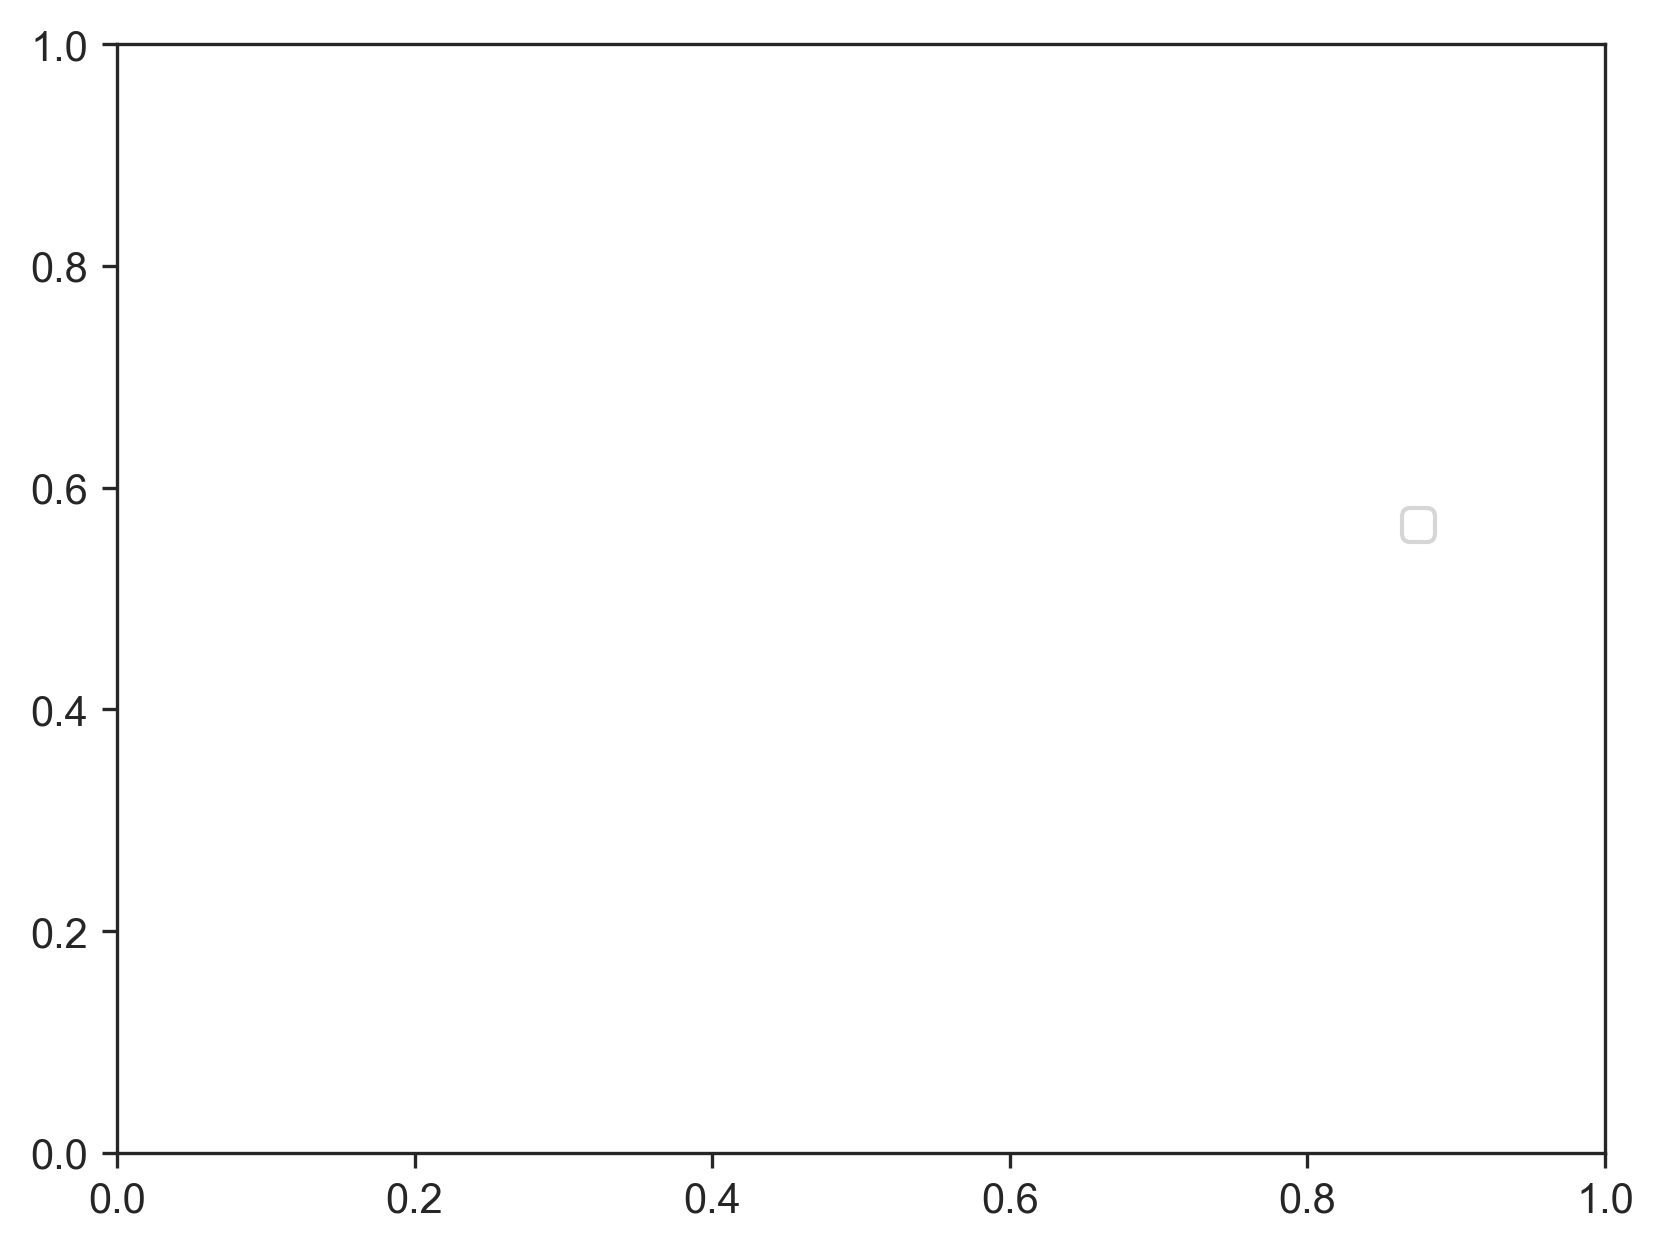

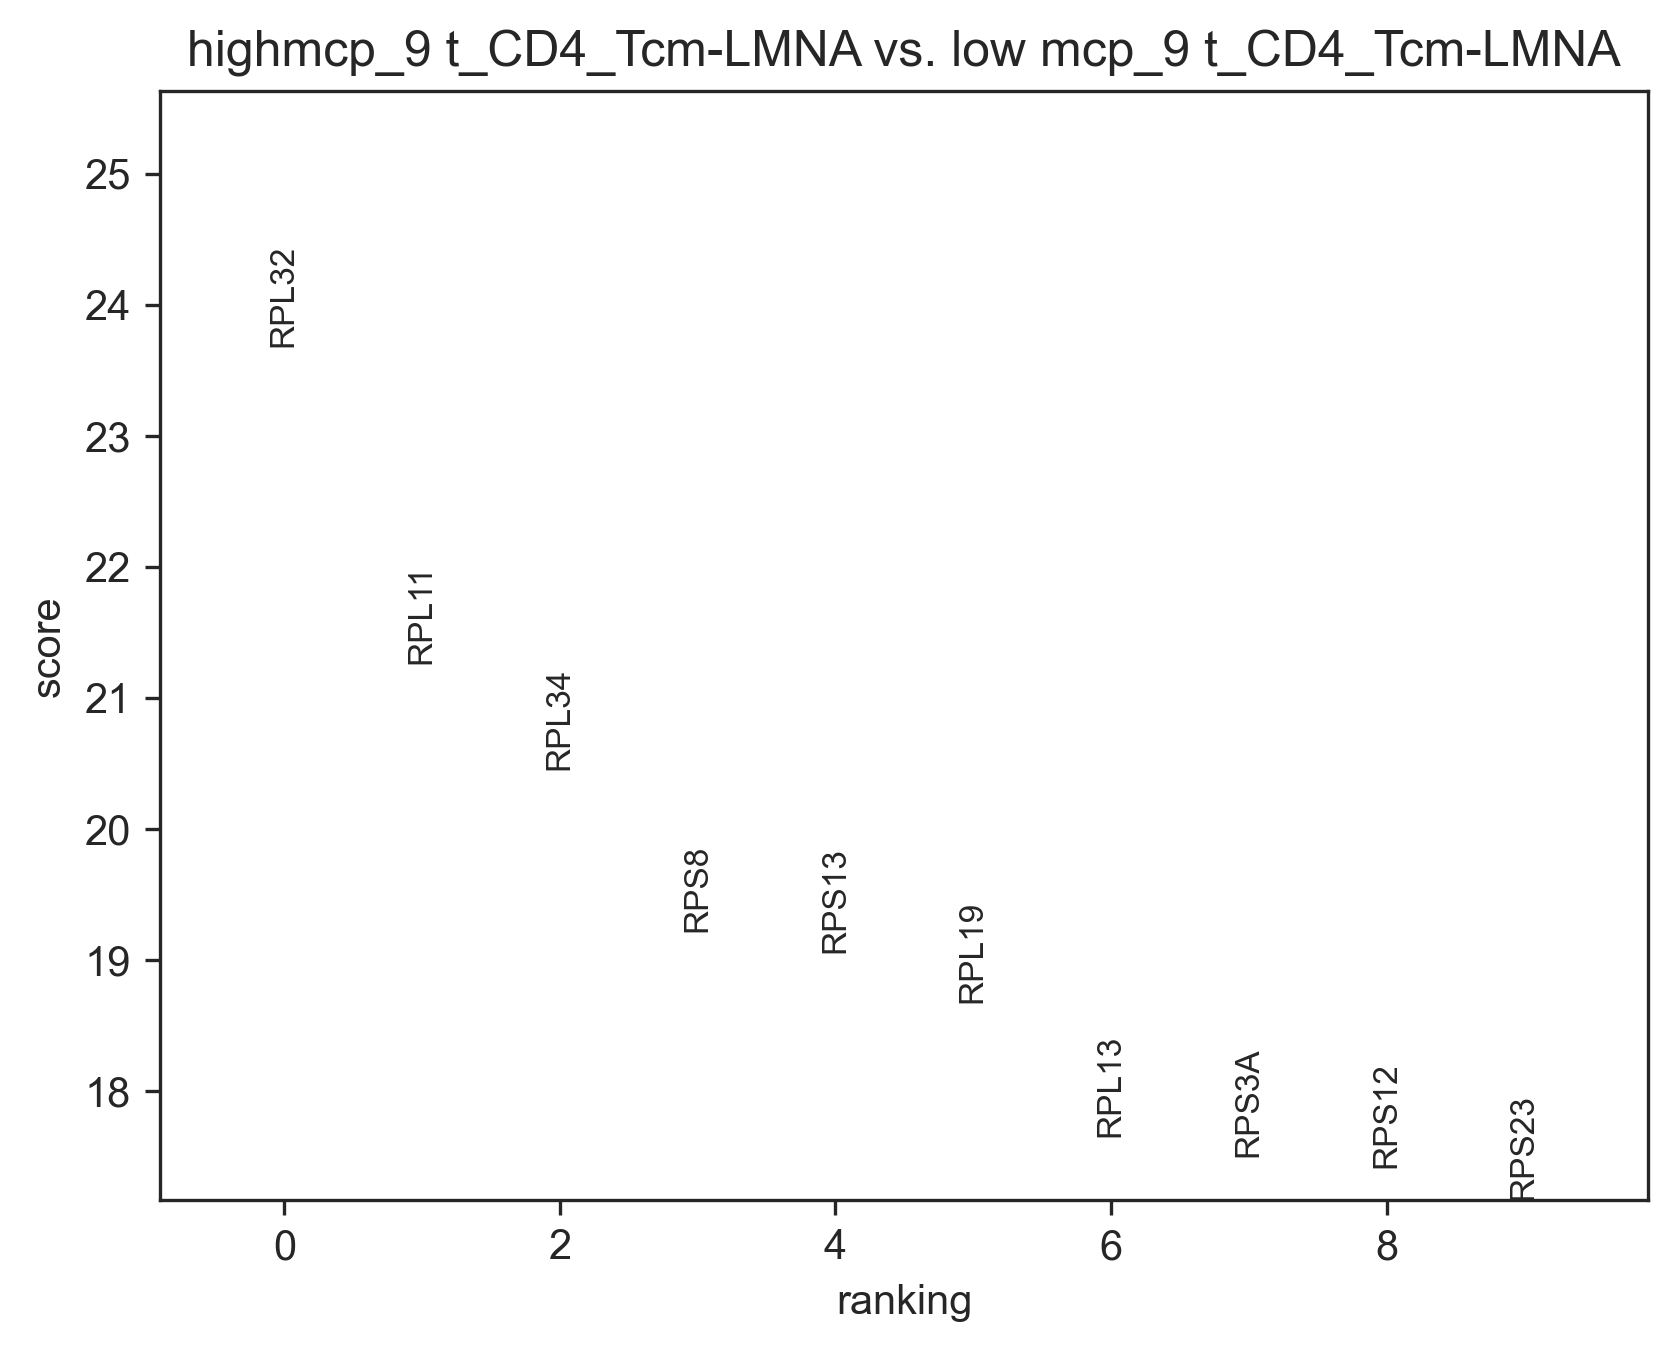

In [26]:
sc.pl.rank_genes_groups(a['t_CD4_Tcm-LMNA'], n_genes=10)


In [23]:
a['t_CD4_Tcm-LMNA']

AnnData object with n_obs × n_vars = 3699 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9', 'extrema'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'Sample_colors', 'Treatment_colors', 'Cluster_colors', 'Efficacy_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
from matplotlib import rcParams
def rank_genes_groups_vertical(
    adata: AnnData,
    groups: Union[str, Sequence[str]] = None,
    n_genes: int = 20,
    gene_symbols: Optional[str] = None,
    key: Optional[str] = 'rank_genes_groups',
    fontsize: int = 8,
    ncols: int = 4,
    sharey: bool = False,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    #ax: Optional[Axes] = None,
    title_override: Optional[str] = None,
    **kwds,
):
    """\
    Plot ranking of genes.
    Parameters
    ----------
    adata
        Annotated data matrix.
    groups
        The groups for which to show the gene ranking.
    gene_symbols
        Key for field in `.var` that stores gene symbols if you do not want to
        use `.var_names`.
    n_genes
        Number of genes to show.
    fontsize
        Fontsize for gene names.
    ncols
        Number of panels shown per row.
    sharey
        Controls if the y-axis of each panels should be shared. But passing
        `sharey=False`, each panel has its own y-axis range.
    {show_save_ax}
    Examples
    --------
    .. plot::
        :context: close-figs
        import scanpy as sc
        adata = sc.datasets.pbmc68k_reduced()
        sc.pl.rank_genes_groups(adata)
    Plot top 10 genes (default 20 genes)
    .. plot::
        :context: close-figs
        sc.pl.rank_genes_groups(adata, n_genes=10)
    .. currentmodule:: scanpy
    See also
    --------
    tl.rank_genes_groups
    """
    if 'n_panels_per_row' in kwds:
        n_panels_per_row = kwds['n_panels_per_row']
    else:
        n_panels_per_row = ncols
    if n_genes < 1:
        raise NotImplementedError(
            "Specifying a negative number for n_genes has not been implemented for "
            f"this plot. Received n_genes={n_genes}."
        )

    reference = str(adata.uns[key]['params']['reference'])
    group_names = adata.uns[key]['names'].dtype.names if groups is None else groups
    # one panel for each group
    # set up the figure
    n_panels_x = min(n_panels_per_row, len(group_names))
    n_panels_y = np.ceil(len(group_names) / n_panels_x).astype(int)

    from matplotlib import gridspec

    fig = plt.figure(
        figsize=(
            n_panels_x * 4,
            n_panels_y * 4.8,
        )
    )
    gs = gridspec.GridSpec(nrows=n_panels_y, ncols=n_panels_x, wspace=0.22, hspace=0.3)

    ax0 = None
    xmin = np.Inf
    xmax = -np.Inf
    for count, group_name in enumerate(group_names):
        gene_names = adata.uns[key]['names'][group_name][:n_genes]
        scores = adata.uns[key]['scores'][group_name][:n_genes]

        # Setting up axis, calculating y bounds
        if sharey:
            ymin = min(ymin, np.min(scores))
            ymax = max(ymax, np.max(scores))

            if ax0 is None:
                ax = fig.add_subplot(gs[count])
                ax0 = ax
            else:
                ax = fig.add_subplot(gs[count], sharey=ax0)
        else:
            ymin = np.min(scores)
            ymax = np.max(scores)
            ymax += 0.3 * (ymax - ymin)

            ax = fig.add_subplot(gs[count])
            ax.set_xlim(ymin-2, ymax)

        ax.set_ylim( n_genes +0.5,0)

        # Mapping to gene_symbols
        if gene_symbols is not None:
            if adata.raw is not None and adata.uns[key]['params']['use_raw']:
                gene_names = adata.raw.var[gene_symbols][gene_names]
            else:
                gene_names = adata.var[gene_symbols][gene_names]

        # Making labels
        for ig, gene_name in enumerate(gene_names):
            ax.text(
                scores[ig],
                ig+1,
                gene_name,
                rotation='horizontal',
                verticalalignment='bottom',
                horizontalalignment='center',
                fontsize=fontsize,
            )
        if title_override is not None:
            ax.set_title(title_override)
        else:
            ax.set_title('{} vs. {}'.format(group_name, reference))
        if count >= n_panels_x * (n_panels_y - 1):
            ax.set_xlabel('score')

        # print the 'score' label only on the first panel per row.
        if count % n_panels_x == 0:
            ax.set_ylabel('ranking')

    if sharey is True:
        ymax += 0.3 * (ymax - ymin)
        ax.set_ylim(ymin, ymax)

    #writekey = f"rank_genes_groups_{adata.uns[key]['params']['groupby']}"
    #savefig_or_show(writekey, show=show, save=save)

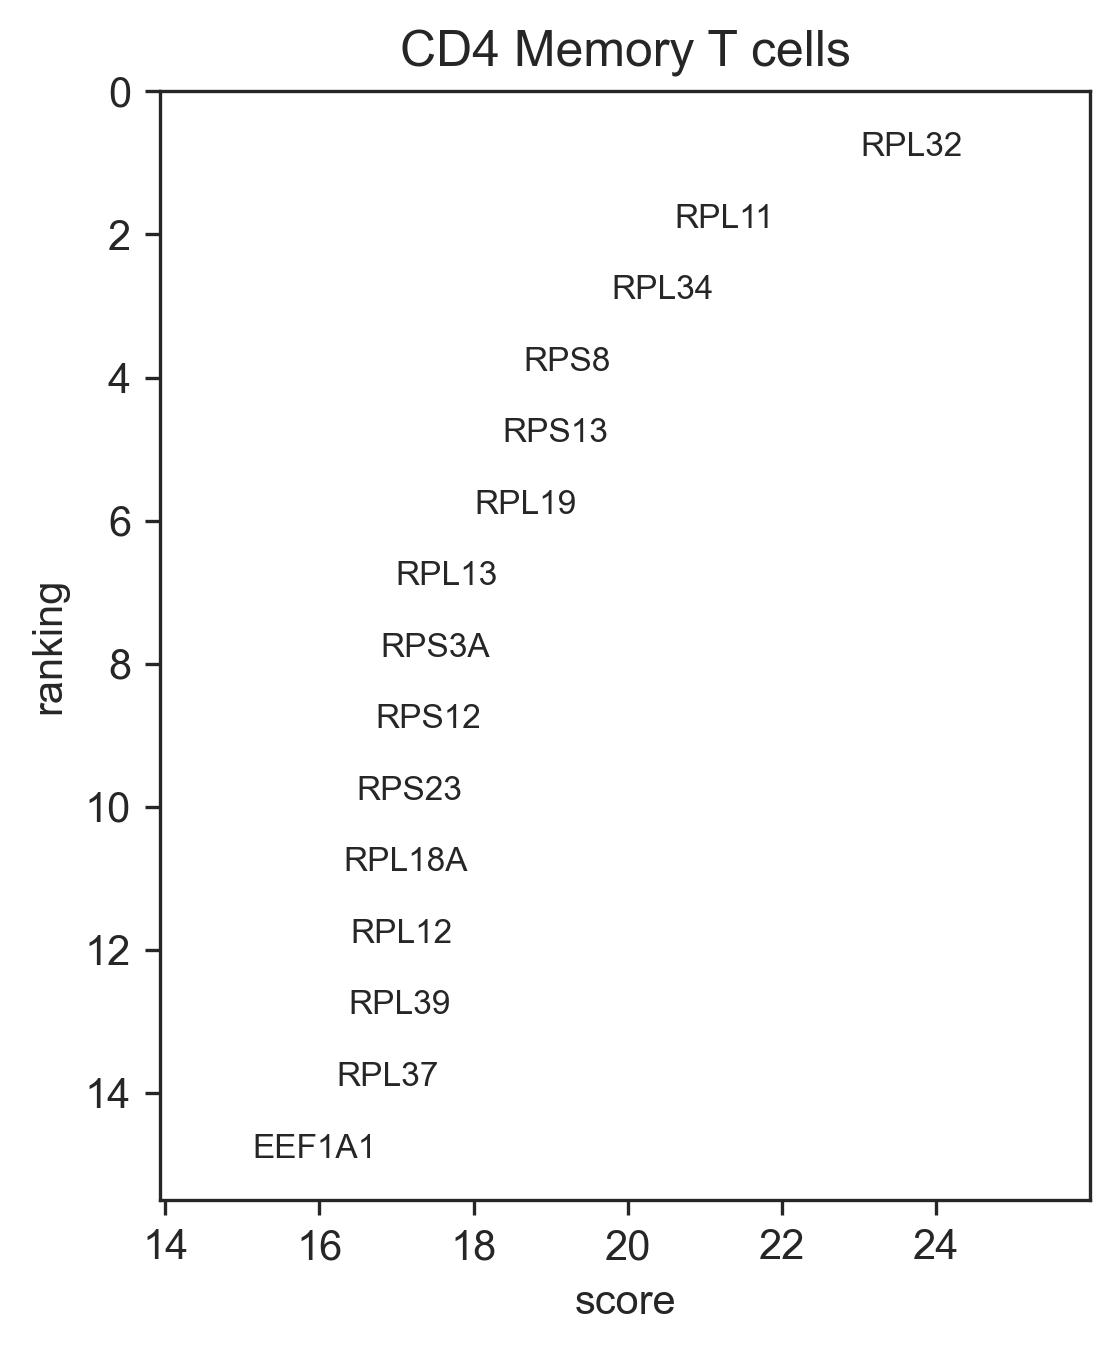

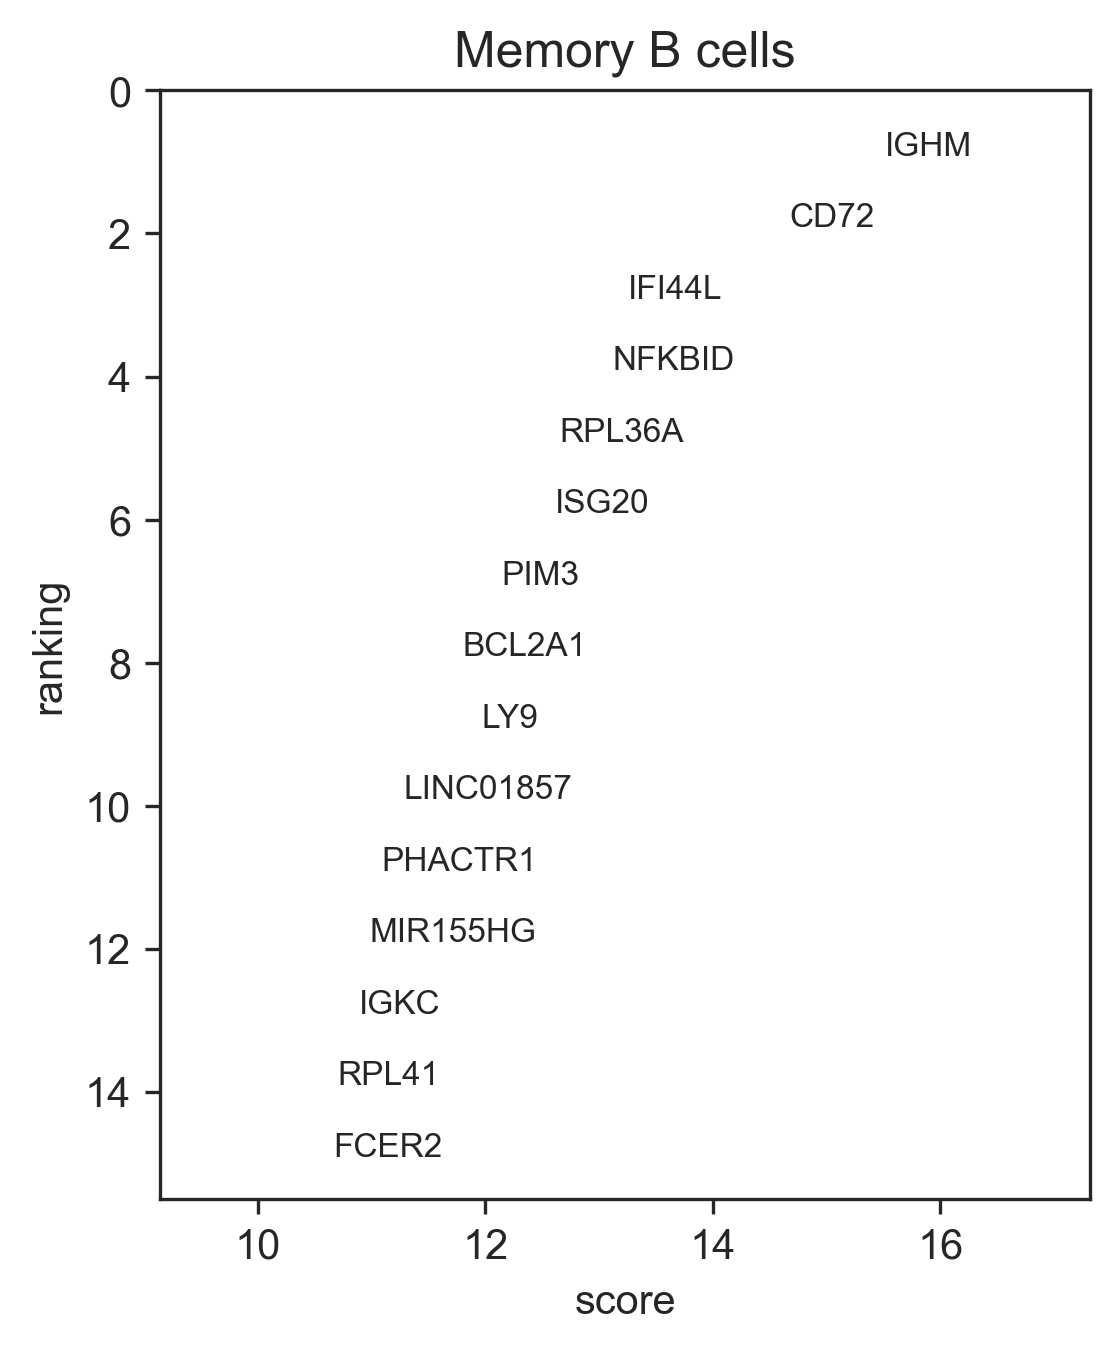

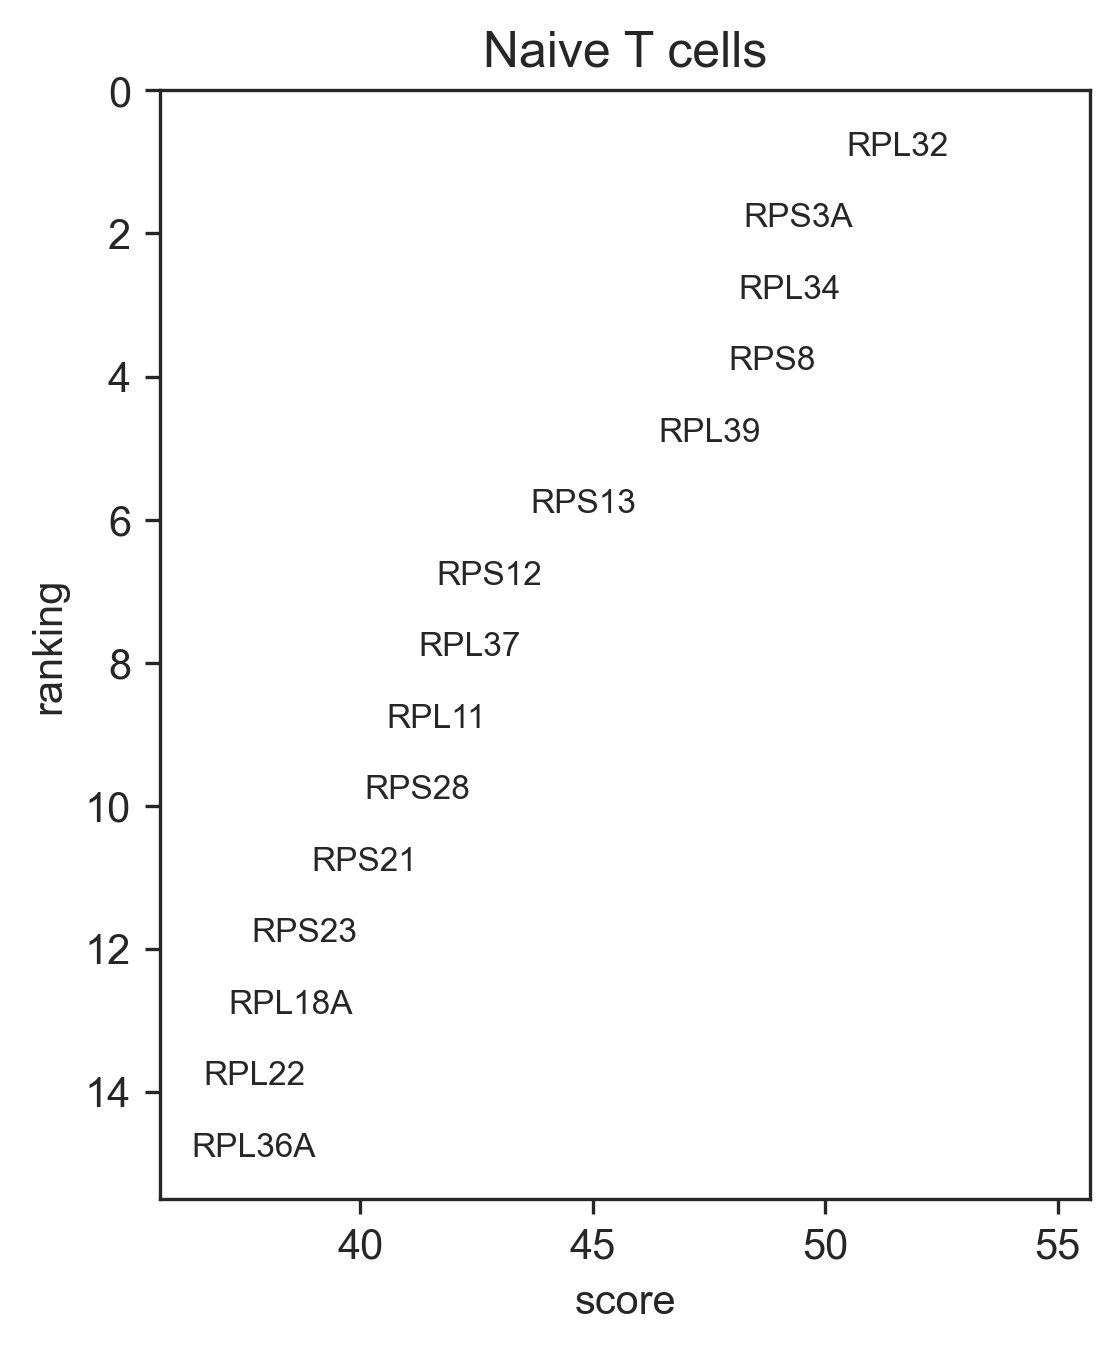

In [92]:
rank_genes_groups_vertical(a['t_CD4_Tcm-LMNA'], title_override="CD4 Memory T cells", n_genes=15)
rank_genes_groups_vertical(a['t_Bmem-CD27'], title_override="Memory B cells", n_genes=15)
rank_genes_groups_vertical(a['t_Tn-LEF1'], title_override="Naive T cells", n_genes=15)



In [99]:
a['t_CD4_Tcm-LMNA'].obs.groupby(['extrema','Efficacy']).size()

extrema                   Efficacy
low mcp_9 t_CD4_Tcm-LMNA  PR          179
                          SD          746
no                        PR          916
                          SD          933
highmcp_9 t_CD4_Tcm-LMNA  PR          667
                          SD          258
dtype: int64

In [ ]:
df.groupby(["Group", "Size"]).size()